In [1]:
import pandas as pd, os
import numpy as np 
import copy
import math
from tqdm.notebook import tqdm 
import re
import warnings
import matplotlib.pyplot as plt
import seaborn as sns
from utils.value_check import * #<=處理體重、脫水量的通則
pd.set_option("display.max_columns", None)
warnings.filterwarnings("ignore")

# 讀取RawData

In [2]:
# 測量值紀錄表
#!!!!!!!!!!!!!!!由於lab_df3、lab_df4與lab_df1、lab_df2只差在是否有B肝C肝，為了防止混淆，後續只使用lab_df3、lab_df4，後續合併命名為lab_df_Anti
# lab_df1 = pd.read_csv('./dataset/drug_lab_base_order/Lab2016_18_utf8.txt', encoding='utf-8') 
# lab_df2 = pd.read_csv('./dataset/drug_lab_base_order/Lab2019_20_utf8.txt', encoding='utf-8')
#後來抓的 lab含'Anti-HBc', 'Anti-HBs', 'Anti-HCV'
lab_df3 = pd.read_csv('./dataset/drug_lab_base_order/Lab_1_utf8.txt', encoding='utf-8') 
lab_df4 = pd.read_csv('./dataset/drug_lab_base_order/Lab_2__utf8.txt', encoding='utf-8')

drug_df = pd.read_csv('./dataset/drug_lab_base_order/Drug2016_20_utf8.txt',encoding='utf-8', on_bad_lines='error') #用藥紀錄表

peri_df1 = pd.read_csv('./dataset/drug_lab_base_order/periHD2016_18_utf8.txt', encoding='utf-8')
peri_df2 = pd.read_csv('./dataset/drug_lab_base_order/periHD2019_20_utf8.txt', encoding='utf-8')

base_df = pd.read_csv('./dataset/drug_lab_base_order/Base2016_20_utf8.txt', encoding='utf-8')

order_df = pd.read_csv('./dataset/drug_lab_base_order/Order2016_20_utf8.txt', encoding='utf-8')

# 合併表格
# lab_df = pd.concat([lab_df1, lab_df2])
peri_df = pd.concat([peri_df1, peri_df2])
lab_df_Anti = pd.concat([lab_df3,lab_df4])

# 資料格式整理
# lab_df.loc[:,'報告日'] = pd.to_datetime(lab_df.loc[:,'報告日'], format='%Y/%m/%d %H:%M')
# lab_df = lab_df.sort_values(["ID","報告日"])#按照ID進行排序再將同一個ID按照報告日排序

drug_df.loc[:,'CHOP3CDATE'] = drug_df.loc[:,'CHOP3CDATE'].astype('int64')

drug_df.loc[:,'CHOP3CDATE'] = drug_df.loc[:,'CHOP3CDATE'] + 191100000000

drug_df.loc[:,'CHOP3CDATE'] = pd.to_datetime(drug_df.loc[:,'CHOP3CDATE'], format='%Y%m%d%H%M')
drug_df = drug_df.sort_values(["ID","CHOP3CDATE"])


print(peri_df.shape)
peri_df.loc[:,'透析開始時間'] = pd.to_datetime(peri_df.loc[:,'透析開始時間'], format='%Y/%m/%d %H:%M')
peri_df = peri_df.sort_values(["ID","透析開始時間"])

# order 醫囑建議：
# 包含後續可能會用到的洗腎時長、透析液Ca(越低越可能掉血壓)
order_df.loc[:,'VCHCDATE'] = pd.to_datetime(order_df.loc[:,'VCHCDATE'], format='%Y/%m/%d %H:%M')

lab_df_Anti.loc[:,'報告日'] = pd.to_datetime(lab_df_Anti.loc[:,'報告日'], format='%Y/%m/%d %H:%M')
lab_df_Anti = lab_df_Anti.sort_values(["ID","報告日"])#按照ID進行排序再將同一個ID按照報告日排序

base_df['生日']= pd.to_datetime(base_df['生日'])
base_df['生日']= base_df['生日'].dt.date

(358833, 61)


In [3]:
peri_df.shape

(358833, 61)

In [4]:
li = drug_df['CHOP3DRGNO'].unique()

In [4]:
# 原始歸人數量
print("原始歸人數量:", len(peri_df['ID'].unique()))
peri_df = peri_df[peri_df['急診門診住院'] == '2.門診']
print("過濾住院、急診歸人數量:", len(peri_df['ID'].unique()))
drug_df = drug_df[(drug_df['CHOP3DRGNO'] == 'IRECO2 ') | (drug_df['CHOP3DRGNO'] == 'IDARB0 ')]
# 過濾住院、急診歸人數量
print(peri_df.shape)
# (301534, 65)

原始歸人數量: 4017
過濾住院、急診歸人數量: 1128
(314407, 61)


In [5]:
# lab_ID = list(set(lab_df['ID'].values))
lab_ID = list(set(lab_df_Anti['ID'].values))
peri_ID = list(set(peri_df['ID'].values))
drug_ID = list(set(drug_df['ID'].values))

# 三個表格的病人ID交集
patient_ID = list(set(lab_ID).intersection(peri_ID, drug_ID))

print(len(patient_ID))
# 755

1051


In [6]:
print(len(set(lab_df_Anti['ID'])))
print(len(set(peri_df['ID'])))
print(len(set(drug_df['ID'])))

3867
1128
1410


In [7]:
#每個表格有交集的ID設成Ture沒有交集設成False
lab_df_Anti = lab_df_Anti[lab_df_Anti['ID'].isin(patient_ID)]
peri_df = peri_df[peri_df['ID'].isin(patient_ID)]
drug_df = drug_df[drug_df['ID'].isin(patient_ID)]

In [8]:
print(len(set(lab_df_Anti['ID'])))
print(len(set(peri_df['ID'])))
print(len(set(drug_df['ID'])))

1051
1051
1051


In [9]:
# 資料格式整理
lab_df_Anti.loc[:,'報告日'] = pd.to_datetime(lab_df_Anti.loc[:,'報告日'], format='%Y/%m/%d %H:%M')
lab_df_Anti = lab_df_Anti.sort_values(["ID","報告日"])#按照ID進行排序再將同一個ID按照報告日排序

peri_df.loc[:,'洗腎紀錄時間'] = pd.to_datetime(peri_df.loc[:,'洗腎紀錄時間'], format='%Y/%m/%d %H:%M')
peri_df['透析開始時間']= pd.to_datetime(peri_df['透析開始時間'])
peri_df['透析開始時間']= peri_df['透析開始時間'].dt.date
peri_df = peri_df.sort_values(["ID","洗腎紀錄時間"])
print(peri_df.shape)

(309556, 61)


# 建構基本欄位(data_df)

In [10]:
#創新的
data_df = pd.DataFrame()
# T0 Featrue
data_df["ID"], data_df["洗腎紀錄時間"], data_df["洗腎紀錄時間去時分"],data_df["急診門診住院"],data_df['入院方式'],data_df["FISTULA"], data_df["GRAFT"], data_df["DLC"],data_df["PERMCATH"],data_df["處置其他結束"]= \
peri_df["ID"], peri_df["洗腎紀錄時間"], peri_df["透析開始時間"],peri_df["急診門診住院"],peri_df['入院方式'],peri_df["FISTULA"], peri_df["GRAFT"], peri_df["DLC"],peri_df["PERMCATH"],peri_df["處置其他結束"]
data_df["開始血壓SBP"] = peri_df["開始血壓SBP"]
data_df["開始血壓DBP"] = peri_df["開始血壓DBP"]
data_df["開始脈搏"] = peri_df["開始脈搏"]
# T1 Featrue
# T2 Featrue
data_df["體溫"] = peri_df["體溫"]
# T3 Featrue
data_df["結束脈搏"] = peri_df["結束脈搏"]
data_df["Hollow fiber clot"] = peri_df["Hollow fiber clot"]

In [11]:
# np.unique(data_df['Hollow fiber clot'].astype(str).values, return_counts=True)

In [12]:
data_df.index = range(len(data_df))
data_df = data_df.drop_duplicates(keep='first', inplace=False)
data_df['洗腎紀錄時間去時分']= pd.to_datetime(data_df['洗腎紀錄時間去時分'])
data_df['洗腎紀錄時間去時分']= data_df['洗腎紀錄時間去時分'].dt.date
data_df.reset_index(inplace=True, drop=True)

### 處理廔管

In [13]:
#廔管不是na補1 ,na補0
# data_df['FISTULA'].replace(["(Lt,Rt,)", '(Lt,)','(Rt,)','Fistula','Fistula(Lt,)','Fistula(Lt,Rt,)','Fistula(Rt,)'],[1,1,1,1,1,1,1], inplace=True) 
# data_df['GRAFT'].replace(['(Lt,)','(Lt,Rt,)','(Rt,)','Graft','Graft(Lt,)','Graft(Lt,Rt,)','Graft(Rt,)'],[1,1,1,1,1,1,1], inplace=True) 
# 2024/04/23修正新資料條件
data_df['FISTULA'].replace(["(Lt,Rt,)", '(Lt,)','(Rt,)','Fistula','Fistula(Lt,)','Fistula(Lt,Rt,)','Fistula(Rt,)','Lt', 'Rt', 'LtRt'],[1,1,1,1,1,1,1,1,1,1], inplace=True) 
data_df['GRAFT'].replace(['(Lt,)','(Lt,Rt,)','(Rt,)','Graft','Graft(Lt,)','Graft(Lt,Rt,)','Graft(Rt,)', 'Lt', 'Rt'],[1,1,1,1,1,1,1,1,1], inplace=True)

data_df['DLC'].replace(['(Lt,)', '(Rt,)', 'Femoral', 'Femoral(Lt,)', 'Femoral(Rt,)', 'Jugular(Rt,)', 'Jugular'],[1,1,1,1,1,1,1], inplace=True) 
data_df['PERMCATH'].replace(['Perm-cath'],[1], inplace=True) 
data_df["FISTULA"] = data_df["FISTULA"].fillna(0)
data_df["GRAFT"] = data_df["GRAFT"].fillna(0)
data_df["DLC"] = data_df["DLC"].fillna(0)
data_df["PERMCATH"] = data_df["PERMCATH"].fillna(0)

In [14]:
indexNames = data_df[(data_df['FISTULA']==0)&(data_df['GRAFT']==0)&(data_df['DLC']==0)&(data_df['PERMCATH']==0)].index
for i in indexNames:
    data_df['FISTULA'][i] = np.nan
    data_df['GRAFT'][i] = np.nan
    data_df['DLC'][i] = np.nan
    data_df['PERMCATH'][i] = np.nan


In [15]:
# 體重部分需要做額外的確認補植
groupby_list = ['ID','FISTULA','GRAFT','DLC','PERMCATH']
data_df.reset_index(inplace=True, drop=True)

temp_df = data_df[groupby_list]
print(print(data_df.isnull().sum()))
temp_df = temp_df.groupby(["ID"], as_index=False).apply(lambda group: group.bfill())
temp_df = temp_df.groupby(["ID"], as_index=False).apply(lambda group: group.ffill())
temp_df.reset_index(inplace=True, drop=True)
data_df[groupby_list] = temp_df
print(data_df.isnull().sum())

ID                       0
洗腎紀錄時間                   0
洗腎紀錄時間去時分                0
急診門診住院                   0
入院方式                  2349
FISTULA               6614
GRAFT                 6614
DLC                   6614
PERMCATH              6614
處置其他結束                3748
開始血壓SBP               2001
開始血壓DBP               2013
開始脈搏                  4003
體溫                    2815
結束脈搏                  4148
Hollow fiber clot    68448
dtype: int64
None
ID                       0
洗腎紀錄時間                   0
洗腎紀錄時間去時分                0
急診門診住院                   0
入院方式                  2349
FISTULA                758
GRAFT                  758
DLC                    758
PERMCATH               758
處置其他結束                3748
開始血壓SBP               2001
開始血壓DBP               2013
開始脈搏                  4003
體溫                    2815
結束脈搏                  4148
Hollow fiber clot    68448
dtype: int64


In [16]:
indexNames = data_df[(data_df['FISTULA'].isna())&(data_df['GRAFT'].isna())&(data_df['DLC'].isna())&(data_df['PERMCATH'].isna())].index
for i in indexNames:
    data_df['FISTULA'][i] = 1 # 
    data_df['GRAFT'][i] = 0
    data_df['DLC'][i] = 0
    data_df['PERMCATH'][i] = 0

In [17]:
data_df = data_df.reset_index(inplace=False, drop=True)
data_df['Catheter'] = data_df['DLC'] + data_df['PERMCATH']
for i in range(len(data_df)):
    if data_df['Catheter'][i]== 2:
        data_df['Catheter'][i]= 1

# 生理數值

In [18]:
# 需要抓天數
# 'ALBUMIN', 'ALT (SGPT)', 'Alk.phosphatase','BUN', 'Ca', 'Na', 'P','MCV','MCH','MCHC',  'HGB','K','AST (SGOT)','Glucose AC','Glucose PC','HGB','HCT','RBC','WBC','Platelet','Creatinine',= 90內的值，否則算miss或9999
# 'Ferritin', 'IRON/TIBC','Intact PTH', 'Iron','BUN (洗腎後)', 'LDL Cholesterol','Bilirubin-T','Cholesterol-T','CRP' = 180內的值，否則算miss或9999
# 'HBs Ag','Anti-HBc', 'Anti-HBs', 'Anti-HCV' = 以最近一筆，否則算miss或9999

# 90 days
lab_df_Anti['檢驗名稱'].replace(
                              ['K', 'HGB', 'HCT', 'RBC', 'WBC', 'Platelet', 'Creatinine', 'MCV', 'MCHC', 'MCH', 'Na', 'Ca', 'BUN', 'AST (SGOT)', 'ALT (SGPT)', 'Alk.phosphatase']
                             ,['K', 'HGB', 'HCT', 'RBC', 'WBC', 'Platelet', 'Creatinine', 'MCV', 'MCHC', 'MCH', 'Na', 'Ca', 'BUN', 'AST (SGOT)', 'ALT (SGPT)', 'Alk.phosphatase']
                             , inplace=True) 
lab_df_Anti['檢驗名稱'].replace(['Glucose AC', 'Glucose,AC', ],'Glucose AC', inplace=True) 
lab_df_Anti['檢驗名稱'].replace(['Glucose,PC', 'Glucose PC', 'GLUCOSE PC', ],'Glucose PC', inplace=True) 
lab_df_Anti['檢驗名稱'].replace(['Albumin', 'ALBUMIN', ],'ALBUMIN', inplace=True) 
lab_df_Anti['檢驗名稱'].replace(['P  (Phosphorus)','P'],'P', inplace=True)

# 180 days
lab_df_Anti['檢驗名稱'].replace(
                              ['TIBC', 'Ferritin', 'BUN (洗腎後)', 'IRON/TIBC', ]
                             ,['TIBC', 'Ferritin', 'BUN (洗腎後)', 'IRON/TIBC', ]
                             , inplace=True) 
lab_df_Anti['檢驗名稱'].replace(['INTACT PTH', 'Intact PTH', ],'Intact PTH', inplace=True)
lab_df_Anti['檢驗名稱'].replace(['IRON (Fe)', 'Iron', ],'Iron', inplace=True) 
lab_df_Anti['檢驗名稱'].replace(['LDL Cholesterol', 'LDL CHOLESTEROL', ],'LDL Cholesterol', inplace=True) 
lab_df_Anti['檢驗名稱'].replace(['Bilirubin-T.', 'BILI-T.', ],'Bilirubin-T', inplace=True) 
lab_df_Anti['檢驗名稱'].replace(['Cholesterol T', 'CHOLESTEROL T.', ],'Cholesterol-T', inplace=True) 
lab_df_Anti['檢驗名稱'].replace(['High Sensitivity CRP', 'CRP', ],'CRP', inplace=True) 

# 一次性判斷
lab_df_Anti['檢驗名稱'].replace(
                              ['Anti-HBs', 'HBs Ag', 'Anti-HBc', 'Anti-HCV', 'HbA1c', ]
                             ,['Anti-HBs', 'HBs Ag', 'Anti-HBc', 'Anti-HCV', 'HbA1c', ]
                             , inplace=True) 

# 暫時無用特徵
if True:
    lab_df_Anti['檢驗名稱'].replace(['Mg', 'Mg (Magnesium)', ],'Useless-Mg', inplace=True) 
    lab_df_Anti['檢驗名稱'].replace(['HDL Cholesterol', 'HDL CHOLESTEROL', ],'Useless-HDL Cholesterol', inplace=True) 
    lab_df_Anti['檢驗名稱'].replace(['Bilirubin-D', 'BILIRUBIN-D.', ],'Useless-Bilirubin-D', inplace=True) 
    lab_df_Anti['檢驗名稱'].replace(
                                ['RPR','VBG-HCO3-','ABG-HCO3-','LDH','r-GT','HBe Ag','Cl']
                                ,['Useless-RPR','Useless-VBG-HCO3','Useless-ABG-HCO3','Useless-LDH','Useless-r-GT','Useless-HBe-Ag','Useless-Cl']
                                , inplace=True) 

In [19]:
print('90天判定特徵')
# '、'.join
print((sorted(['K', 'HGB', 'HCT', 'RBC', 'WBC', 'Platelet', 'Creatinine', 'MCV', 'MCHC', 'MCH', 'Na', 'Ca', 'BUN', 'AST (SGOT)', 'ALT (SGPT)', 'Alk.phosphatase','Glucose AC', 'Glucose PC', 'Albumin', 'P'])))
print('180天判定特徵')
print((sorted(['TIBC', 'Ferritin', 'BUN (洗腎後)', 'IRON/TIBC', 'Intact PTH', 'Iron', 'LDL Cholesterol', 'Bilirubin-T', 'Cholesterol-T', 'CRP'])))
# URR%: 180天 # CRP: 一年做一次  
print('一次性判定特徵')
print((sorted(['Anti-HBs', 'HBs Ag', 'Anti-HBc', 'Anti-HCV', 'HbA1c'])))

90天判定特徵
['ALT (SGPT)', 'AST (SGOT)', 'Albumin', 'Alk.phosphatase', 'BUN', 'Ca', 'Creatinine', 'Glucose AC', 'Glucose PC', 'HCT', 'HGB', 'K', 'MCH', 'MCHC', 'MCV', 'Na', 'P', 'Platelet', 'RBC', 'WBC']
180天判定特徵
['BUN (洗腎後)', 'Bilirubin-T', 'CRP', 'Cholesterol-T', 'Ferritin', 'IRON/TIBC', 'Intact PTH', 'Iron', 'LDL Cholesterol', 'TIBC']
一次性判定特徵
['Anti-HBc', 'Anti-HBs', 'Anti-HCV', 'HBs Ag', 'HbA1c']


### 從Lab DataFrame串BUN

In [20]:
# URR% - 需要以同一天的透析時間做計算!!!
# URR%有效區間為180天
# !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
# new_BUN_SE_df = pd.DataFrame()
BUN_S = lab_df_Anti[lab_df_Anti['檢驗名稱']=='BUN']
BUN_S.loc[:,'報告日'] = pd.to_datetime(BUN_S.loc[:,'報告日']).dt.date
BUN_S.rename(columns={'DATANUM':'DATANUM(前)',},inplace = True)
BUN_E = lab_df_Anti[lab_df_Anti['檢驗名稱']=='BUN (洗腎後)']
BUN_E.loc[:,'報告日'] = pd.to_datetime(BUN_E.loc[:,'報告日']).dt.date
BUN_E.rename(columns={'DATANUM':'DATANUM(後)',},inplace = True)
BUN_SE = BUN_S.merge(BUN_E, on=['ID','報告日'], how='left')
print("洗腎前BUN筆數：{}  洗腎後BUN筆數：{}".format(BUN_S.shape[0], BUN_E.shape[0]))
BUN_SE['DATANUM(前)'] = BUN_SE['DATANUM(前)'].str.replace('Rechecked','')
BUN_SE['DATANUM(前)'] = pd.to_numeric(BUN_SE['DATANUM(前)'])
BUN_SE['DATANUM(後)'] = BUN_SE['DATANUM(後)'].str.replace('Rechecked','')
BUN_SE['DATANUM(後)'] = pd.to_numeric(BUN_SE['DATANUM(後)'])
BUN_SE['URR%'] = round((BUN_SE['DATANUM(前)']-BUN_SE['DATANUM(後)'])/BUN_SE['DATANUM(前)'] * 100,1)
BUN_SE['URR%'] = BUN_SE['URR%'].replace(np.nan, 0)
for i in range(len(BUN_SE)):
    if BUN_SE['URR%'][i]<0:
        BUN_SE['URR%'][i] = round((BUN_SE['DATANUM(後)'][i]-BUN_SE['DATANUM(前)'][i])/BUN_SE['DATANUM(後)'][i] * 100,1)

BUN_SE['檢驗名稱']='URR%'
BUN_SE.rename(columns={'URR%':'DATANUM','DATAUNIT_y':'DATAUNIT'},inplace = True)
BUN_SE = BUN_SE[BUN_SE['DATANUM']!=0][['ID','報告日','檢驗名稱','DATANUM','DATAUNIT']]
print(f"能計算URR%的筆數：{BUN_SE.shape[0]}")
# 將URR%合併至Anti-lab-df
BUN_SE.loc[:,'報告日'] = pd.to_datetime(BUN_SE.loc[:,'報告日'])
lab_df_Anti = pd.concat([lab_df_Anti,BUN_SE])
lab_df_Anti.to_csv('./dataset/drug_lab_base_order/Finishedlab_df.csv', encoding='utf-8-sig', index=False)
BUN_SE.head(10)

洗腎前BUN筆數：40952  洗腎後BUN筆數：8717
能計算URR%的筆數：6038


,ID,報告日,檢驗名稱,DATANUM,DATAUNIT
0,000099H08,2020-06-04 00:00:00,URR%,70.7,mg/dL
8,000099H08,2020-12-10 00:00:00,URR%,71.1,mg/dL
12,000099H08,2021-03-03 00:00:00,URR%,72.7,mg/dL
18,00011T101,2018-03-08 00:00:00,URR%,60.7,mg/dL
22,00011T101,2018-06-07 00:00:00,URR%,75.3,mg/dL
26,00011T101,2018-09-06 00:00:00,URR%,76.6,mg/dL
31,00011T101,2018-12-06 00:00:00,URR%,73.5,mg/dL
35,00011T101,2019-03-07 00:00:00,URR%,74.0,mg/dL
39,00011T101,2019-06-06 00:00:00,URR%,75.4,mg/dL
43,00011T101,2019-09-05 00:00:00,URR%,77.1,mg/dL


In [21]:

# 抓取病人特徵 (lab_df_Anti)
# 04-19: add URR%
feature = ['K', 'HGB', 'HCT', 'RBC', 'WBC', 'Platelet', 'Creatinine', 'MCV', 'MCHC', 'MCH', 'Na', 'K', 'Ca', 'BUN', 'AST (SGOT)', 'ALT (SGPT)', 'Alk.phosphatase', 'Glucose AC', 'Glucose PC', 'ALBUMIN', 'P',
           'TIBC', 'Ferritin', 'BUN (洗腎後)', 'IRON/TIBC', 'Intact PTH', 'Iron', 'LDL Cholesterol', 'Bilirubin-T', 'Cholesterol-T', 'CRP', 'URR%',
           'Anti-HBs', 'HBs Ag', 'Anti-HBc', 'Anti-HCV'
           ]
# **HbA1c後續糖尿病再處理**#
# 將每一個feature加進data的標頭裡然後項目裡都設成NaN
for i in feature:
    data_df[i] = np.nan
data_df.loc[:,'洗腎紀錄時間'] = pd.to_datetime(data_df.loc[:,'洗腎紀錄時間'])

### 根據檢驗值合理天數區間進行串聯

In [23]:
# 將病人的測量值抓入表中，因為每個測量值的時間點不太一定，若以洗腎紀錄時間去抓會有很多missing value，所以用距離洗腎紀錄時間最近的值來補值
if "第一階段處理結果-前半部merge檢驗資料.csv" in os.listdir("./dataset/"):
    data_df = pd.read_csv("./dataset/第一階段處理結果-前半部merge檢驗資料.csv")
else:
# if True:
    for i in tqdm(set(data_df['ID'])): 
        patient_df = data_df[data_df['ID'] == i]  #在data裡面的ID
        feature_df = lab_df_Anti[lab_df_Anti['ID'] == i]    #在原先LAB檔案裡面的ID 等同patient_df的ID
        #在原先LAB檔案裡面的同一個ID裡面的 各個feature
        for j in feature:
            if j in ['ALT (SGPT)', 'AST (SGOT)', 'Albumin', 'Alk.phosphatase', 'BUN', 'Ca', 'Creatinine', 'Glucose AC', 'Glucose PC', 
                     'HCT', 'HGB', 'K', 'MCH', 'MCHC', 'MCV', 'Na', 'P', 'Platelet', 'RBC', 'WBC']: #90內的值，否則算miss或9999
                ths = 90
            elif j in ['BUN (洗腎後)', 'Bilirubin-T', 'CRP', 'Cholesterol-T', 'Ferritin', 
                       'IRON/TIBC', 'Intact PTH', 'Iron', 'LDL Cholesterol', 'TIBC','URR%']: #180內的值，否則算miss或9999
                ths = 180
            else:
                # ['HBs Ag','Anti-HBc', 'Anti-HBs', 'Anti-HCV', {其他特徵}]:#以最近一筆，否則算miss或9999
                ths = 99999999 #無限制
            one_feature_df = feature_df[feature_df['檢驗名稱'] == j]
            time1 = patient_df['洗腎紀錄時間'].values #data裡面我們設立的開始時間欄位
            time2 = one_feature_df['報告日'].values #原先LAB裡面報告日欄位
            if len(time2) == 0:
                continue
            else:    
                closestTimestamp = []
                for k in time1:
                    closestTimestamp.append(min(time2, key=lambda b: abs(k-b))) 
                count = 0
                for index, row in patient_df.iterrows():
                    if (data_df.loc[index, '洗腎紀錄時間'] - one_feature_df[one_feature_df['報告日'] == closestTimestamp[count]]['報告日']).values[0].days>ths:
                        # data_df.loc[index,j] = np.nan
                        data_df.loc[index,j] = "enough far"
                        # print(f"{} - enough far")
                        # print(f"{data_df.loc[index, '洗腎紀錄時間']} => {closestTimestamp[count]}")
                    else:
                        data_df.loc[index,j] = one_feature_df[one_feature_df['報告日'] == closestTimestamp[count]]['DATANUM'].values[0]
                    # data_df.loc[index,"抽血檢驗時間"] = closestTimestamp[count]
                    
                    count+=1
            # break
        # break
    print(data_df['ID'].nunique(dropna=True))
    data_df.to_csv("./dataset/第一階段處理結果-前半部merge檢驗資料.csv", index=False, encoding='utf-8-sig')

In [24]:
data_df.replace("enough far", np.nan, inplace=True)

In [25]:
temp = data_df[data_df.columns.drop(['處置其他結束','開始脈搏','結束脈搏','開始脈搏','開始血壓SBP', '開始血壓DBP','體溫','Hollow fiber clot'])]
temp = temp.isnull().sum(axis=1)
temp = pd.DataFrame({"ID":data_df['ID'].values, "count":temp.values})
temp = temp[temp['count']!=0]
print(f"共 {temp.drop_duplicates(subset='ID').shape[0]} 個病人有遺失值")
# 原先17個特徵有320個病人有遺失值

共 1042 個病人有遺失值


In [26]:
# 透析液 Ca
# 串order 以最近一筆醫囑為主
# nan設為9999
order_df_filter = order_df[['ID','VCHCDATE','透析液 Ca']]
order_df_filter = order_df_filter.sort_values(["ID","VCHCDATE"])#按照ID進行排序再將同一個ID按照報告日排序
order_df_filter.loc[:,'VCHCDATE'] = pd.to_datetime(order_df_filter.loc[:,'VCHCDATE'])
data_df.loc[:,'洗腎紀錄時間'] = pd.to_datetime(data_df.loc[:,'洗腎紀錄時間'])
order_df_filter.head(5)

,ID,VCHCDATE,透析液 Ca
48300,000099H08,2020-05-16 16:47:00,3.5
47735,000099H08,2020-05-20 07:09:00,3.5
50303,000099H08,2020-05-21 08:49:00,3.5
48370,000099H08,2020-05-21 09:08:00,3.5
47247,000099H08,2020-05-26 09:05:00,3.5


### 從Order DataFrame串Ca

In [27]:
data_df['透析液 Ca'] = np.nan
for i in tqdm(set(data_df['ID'])): 
    patient_df = data_df[data_df['ID'] == i]  #在data裡面的ID
    feature_df = order_df_filter[order_df_filter['ID'] == i]    #在原先LAB檔案裡面的ID 等同patient_df的ID
    #在原先LAB檔案裡面的同一個ID裡面的 各個feature
    # j = Ca
    j = '透析液 Ca'
    time1 = patient_df['洗腎紀錄時間'].values #data裡面我們設立的開始時間欄位
    time2 = feature_df['VCHCDATE'].values #原先LAB裡面報告日欄位
    # break
    if len(time2) == 0:
        continue
    else:    
        closestTimestamp = []
        for k in time1:
            closestTimestamp.append(min(time2, key=lambda b: abs(k-b))) 
        count = 0
        for index, row in patient_df.iterrows():
            data_df.loc[index,j] = feature_df[feature_df['VCHCDATE'] == closestTimestamp[count]]['透析液 Ca'].values[0]
            # data_df.loc[index,"抽血檢驗時間"] = closestTimestamp[count]
            count+=1
    # break

  0%|          | 0/1051 [00:00<?, ?it/s]

### 處理BC肝

In [28]:
# BC肝
# HCV後續在處理
# 提醒明翰

if "第一階段處理結果-中半部檢驗資料[HCV]補值.csv" in os.listdir("./dataset/"):
    data_df = pd.read_csv("./dataset/第一階段處理結果-中半部檢驗資料[HCV]補值.csv")
else:
    data_df['洗腎紀錄時間']= pd.to_datetime(data_df['洗腎紀錄時間'])
    data_df.rename(columns={'Anti-HBc':'HBc','Anti-HBs':'HBs','Anti-HCV':'HCV','HBs Ag':'HBsAg'},inplace = True)
    for i in tqdm(range(len(data_df['ID']))):
        if pd.isnull(data_df.HBsAg[i]) == False:
            if 'Non' in data_df['HBsAg'][i]:
                data_df['HBsAg'][i] = '0'
            elif 'Non' not in data_df['HBsAg'][i]:
                data_df['HBsAg'][i] = '1'
        
        if pd.isnull(data_df.HBc[i]) == False:
            if 'Non' in data_df['HBc'][i]:
                data_df['HBc'][i] = '0'
            elif 'Non' not in data_df['HBc'][i]:
                data_df['HBc'][i] = '1'
        
        if pd.isnull(data_df.HBs[i]) == False:
            if 'Non' in data_df['HBs'][i]:
                data_df['HBs'][i] = '0'
            elif 'Negative' in data_df['HBs'][i]:
                data_df['HBs'][i] = '0'
            elif 'Non' not in data_df['HBs'][i]:
                data_df['HBs'][i] = '1'
                
        if pd.isnull(data_df.HCV[i]) == False:
            if 'Non' in data_df['HCV'][i]:
                data_df['HCV'][i] = '0'
            elif 'Non' not in data_df['HCV'][i]:
                data_df['HCV'][i] = '1'
    data_df.to_csv("./dataset/第一階段處理結果-中半部檢驗資料[HCV]補值.csv", index=False, encoding='utf-8-sig')

  0%|          | 0/308135 [00:00<?, ?it/s]

In [29]:
data_df.describe()

,洗腎紀錄時間,FISTULA,GRAFT,DLC,PERMCATH,Catheter,透析液 Ca
count,308135,308135.000000,308135.000000,308135.000000,308135.000000,308135.000000,307348.000000
mean,2018-08-30 01:48:58.561215232,0.840044,0.130631,0.000844,0.066597,0.066747,2.921369
min,2016-01-01 07:35:00,0.000000,0.000000,0.000000,0.000000,0.000000,2.500000
25%,2017-07-04 07:45:00,1.000000,0.000000,0.000000,0.000000,0.000000,2.500000
50%,2018-09-18 17:36:00,1.000000,0.000000,0.000000,0.000000,0.000000,3.000000
75%,2019-11-11 07:35:00,1.000000,0.000000,0.000000,0.000000,0.000000,3.500000
max,2020-12-31 18:45:00,1.000000,1.000000,1.000000,1.000000,1.000000,3.500000
std,NaN,0.366566,0.336997,0.029036,0.249324,0.249583,0.423761


In [30]:
# # 修正新特徵
# 'Hollow fiber clot'後續再處理
new_feature = ['K', 'AST (SGOT)', 'Glucose AC', 'Glucose PC', 'HGB', 'HCT', 'RBC', 'WBC', 'Platelet', 'Creatinine', 'LDL Cholesterol', 'Bilirubin-T', 'Cholesterol-T', 'TIBC', 'CRP']
data_df[new_feature] = data_df[new_feature].astype(str)
for f in new_feature:
    data_df[f] = data_df[f].apply(lambda x: re.sub(r'[^0-9\.-]', '', x))
    data_df[f] = data_df[f].str.replace("Rechecked", '')
    data_df[f].replace(['nan'],9999.0,inplace=True)
    data_df[f] = pd.to_numeric(data_df[f])
    data_df[f].replace(np.nan,9999.0,inplace=True)
# for f in new_feature:
#     print(f)
#     print(np.sort(data_df[f].unique()).astype(str))
#     # data_df[f] = pd.to_numeric(data_df[f])
# print("end")
    

In [31]:
#判斷HBV
# HBV後續在處理
data_df[['HBs','HBc','HBsAg']] = data_df[['HBs','HBc','HBsAg']].astype(float)
if "第一階段處理結果-中半部檢驗資料[HBV]補值.csv" in os.listdir("./dataset/"):
    data_df = pd.read_csv("./dataset/第一階段處理結果-中半部檢驗資料[HBV]補值.csv")
else:
    data_df['HBV'] = np.nan
    for i in range(len(data_df['HBV'])):
        if (data_df['HBV'][i] == 1) |(data_df['HBV'][i] == 0):
            continue
        if data_df['HBs'][i] == 1:
            data_df['HBV'][i] = 0
        elif data_df['HBs'][i] == 0:
            if data_df['HBc'][i] == 1:
                data_df['HBV'][i] = 1
            elif data_df['HBc'][i] == 0:
                data_df['HBV'][i] = 0
            elif data_df['HBsAg'][i] == 1:
                data_df['HBV'][i] = 1
            else:
                data_df['HBV'][i] = 0
        if data_df['HBsAg'][i] == 1:
            data_df['HBV'][i] = 1
        elif data_df['HBsAg'][i] == 0:
            data_df['HBV'][i] = 0
    data_df.to_csv("./dataset/第一階段處理結果-中半部檢驗資料[HBV]補值.csv", index=False, encoding='utf-8-sig')

In [32]:
# ****************************************
#只修正檢驗特徵，生理數值稍後處理
# ****************************************
# 抽血檢驗資料二次處理 - 轉成float type
# 處理非純數字的資料
drop_cols = ['ID', '洗腎紀錄時間', '洗腎紀錄時間去時分', '急診門診住院','入院方式','開始血壓SBP', '開始血壓DBP', '開始脈搏', '體溫', '結束脈搏','Hollow fiber clot','處置其他結束']
for cols_2_num in data_df.columns.drop(drop_cols):
    # print(cols_2_num)
    data_df[cols_2_num] = data_df[cols_2_num].astype(str).apply(lambda x: x.replace("rechecked",'') if 'rechecked' in x else x)
    data_df[cols_2_num] = data_df[cols_2_num].astype(str).apply(lambda x: x.replace("Rechecked",'') if 'Rechecked' in x else x)
    data_df[cols_2_num] = data_df[cols_2_num].astype(str).apply(lambda x: 1 if "(Lt,Rt,)" in x else x)
    data_df[cols_2_num] = data_df[cols_2_num].astype(str).apply(lambda x: np.nan if "nan" in x else x)
    # data_df[cols_2_num] = data_df[cols_2_num].astype(str).apply(lambda x: x.replace("Rechecked",'')if 'Rechecked' else x)
    data_df[cols_2_num] = data_df[cols_2_num].replace(['<5','<3',"<0.7",">1450.0","<3.0","<1.0"], [5,3,0.7,1450,3.0,1.0])
    data_df[cols_2_num] = data_df[cols_2_num].replace(["96.2枯R\腎過程中抽的血"], [96.2])
    data_df[cols_2_num] = pd.to_numeric(data_df[cols_2_num])
# 抽血檢驗資料二次處理 -  將np.nan轉成9999.0 [pass]
    # data_df[cols_2_num] = data_df[cols_2_num].replace(np.nan, 9999.0)

In [33]:
# # missing value統計分佈圖
# temp_null_df = data_df.isnull()
# temp_null_df['ID'] = data_df['ID']
# temp_null_df = temp_null_df.drop(columns=['洗腎紀錄時間','洗腎紀錄時間去時分','急診門診住院'])
# temp_null_df = temp_null_df.drop(columns=drop_cols)
# temp_null_df[temp_null_df.columns[1::]] = temp_null_df[temp_null_df.columns[1::]]
# temp_null_df['error_count'] = temp_null_df[temp_null_df.columns[1::]].sum(axis=1)
# temp_null =np.unique(temp_null_df['error_count'].values, return_counts=True)
# x = temp_null[0][1::]
# h = temp_null[1][1::]
# h_2 = h+50
# sns.barplot(x=x, y=h_2)

# for i in range(len(x)):
#     plt.text(x=i, y=h_2[i]+1, s=str(h[i]), ha='center', va='bottom')
# # plt.xticks(range(min(x), max(x)+1, 1))
# # plt.yticks(sorted(h),rotation=0)
# plt.xlabel('miss total')
# plt.ylabel('miss count')
# plt.title("lab miss distributed")
# plt.show()

In [34]:
# null_list = np.unique(temp_null_df[(temp_null_df['error_count']==5)]['ID'].astype(str).values, return_counts=True)
# null_list = pd.DataFrame({"ID":null_list[0],"遺失筆數":null_list[1]}).sort_values(by='遺失筆數', ascending=False)
# null_list.reset_index(inplace=True, drop=True)
# print(null_list.head(10))
# level = 0
# print(f"\nID: {null_list.loc[level,'ID']} 共有{data_df[data_df['ID']==null_list.loc[level,'ID']].shape[0]}筆紀錄")

In [35]:
# temp = data_df.drop(['開始血壓SBP', '開始血壓DBP', '開始脈搏', '體溫', '結束脈搏','Hollow fiber clot','處置其他結束'], axis=1).isnull().sum(axis=1)
# temp = pd.DataFrame({"ID":data_df['ID'].values, "count":temp.values})
# temp = temp[temp['count']!=0]
# print(f"共 {temp.drop_duplicates(subset='ID').shape[0]} 個病人有遺失值")

In [36]:
print(data_df.columns.drop(drop_cols))
# 將檢測值為np.nan全轉成9999.0
data_df[data_df.columns.drop(drop_cols)] = data_df[data_df.columns.drop(drop_cols)].fillna(9999.0)

Index(['FISTULA', 'GRAFT', 'DLC', 'PERMCATH', 'Catheter', 'K', 'HGB', 'HCT',
       'RBC', 'WBC', 'Platelet', 'Creatinine', 'MCV', 'MCHC', 'MCH', 'Na',
       'Ca', 'BUN', 'AST (SGOT)', 'ALT (SGPT)', 'Alk.phosphatase',
       'Glucose AC', 'Glucose PC', 'ALBUMIN', 'P', 'TIBC', 'Ferritin',
       'BUN (洗腎後)', 'IRON/TIBC', 'Intact PTH', 'Iron', 'LDL Cholesterol',
       'Bilirubin-T', 'Cholesterol-T', 'CRP', 'URR%', 'HBs', 'HBsAg', 'HBc',
       'HCV', '透析液 Ca', 'HBV'],
      dtype='object')


### 將PTH轉為類別數值

In [37]:
# Intact PTH
# !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
for i in range(len(data_df)):
    if data_df['Intact PTH'][i]<70:
        data_df['Intact PTH'][i] = 3
    elif (data_df['Intact PTH'][i]>=70)&(data_df['Intact PTH'][i]<300):
        data_df['Intact PTH'][i] = 2
    elif (data_df['Intact PTH'][i]>=300)&(data_df['Intact PTH'][i]<800):
        data_df['Intact PTH'][i] = 1
    elif (data_df['Intact PTH'][i]==9999.0):
        data_df['Intact PTH'][i] = 9999.0
    elif data_df['Intact PTH'][i]>=800:
        data_df['Intact PTH'][i] = 0

# 生日、性別

In [38]:
data_df = data_df.merge(base_df, on=['ID'], how='left')
del(data_df['首次透析日期'])
data_df['算年齡'] = data_df['洗腎紀錄時間']
data_df['算年齡']= pd.to_datetime(data_df['算年齡'])
data_df['算年齡']= data_df['算年齡'].dt.date

In [39]:
print(len(set(data_df['ID'])))

1051


In [40]:
data_df['age'] = np.nan
for index in range(len(data_df)):
    data_df['age'][index] = math.floor((data_df['算年齡'][index] - data_df['生日'][index]).days/365.25)
# del(data_df['算年齡'])
# del(data_df['生日'])
data_df = data_df.replace('男', 1)
data_df = data_df.replace('女', 0)

In [41]:
if "第一階段處理結果-中半部檢驗資料[sex-age]補值.csv" in os.listdir("./dataset/"):
    data_df = pd.read_csv("./dataset/第一階段處理結果-中半部檢驗資料[sex-age]補值.csv")
else:
    data_df.to_csv("./dataset/第一階段處理結果-中半部檢驗資料[sex-age]補值.csv", index=False, encoding='utf-8-sig')


# 體重調整

In [42]:
Peri_weight = pd.DataFrame()

Peri_weight["ID"], Peri_weight["洗腎紀錄時間去時分"] = peri_df["ID"], peri_df["洗腎紀錄時間"]
Peri_weight['體重1開始'], Peri_weight["體重2標準體重"],Peri_weight["體重結束"] = peri_df['體重1開始'], peri_df["體重2標準體重"], peri_df["體重結束"]
Peri_weight["體重實際脫水"], Peri_weight["體重機器顯示"], Peri_weight["體重3應脫水"] = peri_df["體重實際脫水"], peri_df["體重機器顯示"], peri_df["體重3應脫水"]

Peri_weight['洗腎紀錄時間去時分']= pd.to_datetime(Peri_weight['洗腎紀錄時間去時分'])
Peri_weight['洗腎紀錄時間去時分']= Peri_weight['洗腎紀錄時間去時分'].dt.date
print("============篩選前============")
print(Peri_weight.isnull().sum())
print(Peri_weight.shape)
Peri_weight = Peri_weight.drop_duplicates(keep='first', inplace=False) #假如有兩筆或數筆完整資料長一模一樣，則留第一筆資料(假定有資料重複紀錄)
# print(Peri_weight.shape)
Peri_weight = Peri_weight.drop_duplicates(subset=['ID','洗腎紀錄時間去時分'],keep='last', inplace=False) #假如有兩筆或數筆的ID和時間一樣，則保留最後一筆資料(假定第二次或最後一次才有正確記錄)
# print(Peri_weight.shape)
Peri_weight.index = range(len(Peri_weight))
print("============篩選後============")
print(Peri_weight.isnull().sum())
print(Peri_weight.shape)

============篩選前============
ID              0
洗腎紀錄時間去時分       0
體重1開始        1998
體重2標準體重       963
體重結束         3936
體重實際脫水       4059
體重機器顯示       3672
體重3應脫水       7451
dtype: int64
(309556, 8)
============篩選後============
ID              0
洗腎紀錄時間去時分       0
體重1開始        1307
體重2標準體重       790
體重結束         2448
體重實際脫水       2572
體重機器顯示       2203
體重3應脫水       6710
dtype: int64
(305543, 8)


In [43]:
print(len(set(data_df['ID'])))

1051


In [44]:
data_df['洗腎紀錄時間'] = pd.to_datetime(data_df['洗腎紀錄時間']).dt.date
data_df['洗腎紀錄時間去時分'] = pd.to_datetime(data_df['洗腎紀錄時間去時分']).dt.date
data_df['算年齡'] = pd.to_datetime(data_df['算年齡']).dt.date
Peri_weight[['體重1開始','體重2標準體重','體重結束','體重實際脫水','體重機器顯示','體重3應脫水']] = Peri_weight[['體重1開始','體重2標準體重','體重結束','體重實際脫水','體重機器顯示','體重3應脫水']].astype(str) #防止後續處理小數點時出現浮點數錯誤

In [45]:
data_df = pd.merge(data_df, Peri_weight, on=['ID','洗腎紀錄時間去時分'], how='left')
print(len(set(data_df['ID'])))

1051


In [2]:
if "第一階段處理結果-後半部檢驗資料[粗布處理體重]補值.csv" in os.listdir("./dataset/"):
    data_df = pd.read_csv("./dataset/第一階段處理結果-後半部檢驗資料[粗布處理體重]補值.csv")
else:
    # 修正字串轉數字步驟，原先做法容易讓脫水量的值出現異常
    # flist =['體重2標準體重','體重結束','體重實際脫水','體重機器顯示']
    flist =['體重1開始','體重2標準體重','體重結束']
    for f in flist:
        print(f)
        for i in tqdm(range(len(data_df))):
            if not pd.isnull(data_df[f][i]):
                data_df.loc[i,f] = ''.join([x for idx, x in enumerate(data_df[f][i]) if x.isdigit() or x=='.' or (idx==0 and x=='-')]) 
    data_df.to_csv("./dataset/第一階段處理結果-後半部檢驗資料[粗布處理體重]補值.csv", index=False, encoding='utf-8-sig')
data_df[['體重1開始','體重2標準體重','體重結束','體重實際脫水','體重機器顯示','體重3應脫水']] = data_df[['體重1開始','體重2標準體重','體重結束','體重實際脫水','體重機器顯示','體重3應脫水']].astype(str) #防止後續處理小數點時出現浮點數錯誤


In [3]:
# 乾體重可以根據前一次或下一次做補植(體重1開始): update = 以使用9999補異常體重(體重1開始)
data_df['體重1開始'].replace(['Nan','nan','.','0','0.0'], '9999', inplace=True) 
data_df['體重1開始'] = data_df['體重1開始'].apply(lambda x: weight_process(x)) #使用體重通則處理錯誤數據
data_df['體重1開始'] = pd.to_numeric(data_df['體重1開始'])
temp = data_df[data_df['體重1開始']!=9999]
temp = temp[(data_df['體重1開始']>150)|(data_df['體重1開始']<20)]
print(f"體重1開始 - 剩餘{temp.shape[0]}筆資料有異常")
temp.to_csv("./dataset/outlier/第一階段處理結果-開始體重outlier_error.csv", index=False, encoding='utf-8-sig')
data_df['體重1開始'] = data_df['體重1開始'].apply(lambda x: 9999.0 if x>150 else x) #把大於150公斤的紀錄改為9999.0
data_df['體重1開始'] = data_df['體重1開始'].apply(lambda x: 9999.0 if x<20 else x) #把小於20公斤的紀錄改為9999.0

已經處理錯誤數值 B:(551.6) A:(551.6 => 55)

已經處理錯誤數值 B:(584.0) A:(584.0 => 58)

已經處理錯誤數值 B:(7.0) A:(7.0 => 70)

已經處理錯誤數值 B:(536.0) A:(536.0 => 53)

已經處理錯誤數值 B:(6.5) A:(6.5 => 65)

已經處理錯誤數值 B:(935.5) A:(935.5 => 93)

已經處理錯誤數值 B:(518.0) A:(518.0 => 51)

已經處理錯誤數值 B:(7405.0) A:(7405.0 => 74.0)

已經處理錯誤數值 B:(657.0) A:(657.0 => 65)

已經處理錯誤數值 B:(681.0) A:(681.0 => 68)

已經處理錯誤數值 B:(655.0) A:(655.0 => 65)

已經處理錯誤數值 B:(647.0) A:(647.0 => 64)

已經處理錯誤數值 B:(655.0) A:(655.0 => 65)

已經處理錯誤數值 B:(6.9) A:(6.9 => 69)

已經處理錯誤數值 B:(161.0) A:(161.0 => 16.0)

已經處理錯誤數值 B:(646.0) A:(646.0 => 64)

已經處理錯誤數值 B:(460.7) A:(460.7 => 46)

已經處理錯誤數值 B:(7.3) A:(7.3 => 73)

已經處理錯誤數值 B:(758.2) A:(758.2 => 75)

已經處理錯誤數值 B:(3.7) A:(3.7 => 37)

已經處理錯誤數值 B:(825.0) A:(825.0 => 82)

已經處理錯誤數值 B:(159.4) A:(159.4 => 15.0)

已經處理錯誤數值 B:(160.0) A:(160.0 => 16.0)

已經處理錯誤數值 B:(161.1) A:(161.1 => 16.0)

已經處理錯誤數值 B:(634.5) A:(634.5 => 63)

已經處理錯誤數值 B:(5802.0) A:(5802.0 => 58.0)

已經處理錯誤數值 B:(797.0) A:(797.0 => 79)

已經處理錯誤數值 B:(478.0) A:(478.0 => 4

In [51]:
if "第一階段處理結果-後半部檢驗資料[1-開始體重]補值.csv" in os.listdir("./dataset/"):
    data_df = pd.read_csv("./dataset/第一階段處理結果-後半部檢驗資料[1-開始體重]補值.csv")
else:
    data_df.to_csv("./dataset/第一階段處理結果-後半部檢驗資料[1-開始體重]補值.csv", index=False, encoding='utf-8-sig')
data_df[['體重1開始','體重2標準體重','體重結束','體重實際脫水','體重機器顯示','體重3應脫水']] = data_df[['體重1開始','體重2標準體重','體重結束','體重實際脫水','體重機器顯示','體重3應脫水']].astype(str) #防止後續處理小數點時出現浮點數錯誤

In [52]:
data_df['體重2標準體重'].replace(['-','nan','Nan'],"9999.0", inplace=True)
data_df['體重2標準體重'] = data_df['體重2標準體重'].apply(lambda x: weight_process(x)) #使用體重通則處理錯誤數據
data_df['體重2標準體重'] = pd.to_numeric(data_df['體重2標準體重'])
data_df["體重2標準體重"] = data_df["體重2標準體重"].fillna(9999) #把np.nan的紀錄改為9999.0
data_df['體重2標準體重'] = data_df['體重2標準體重'].apply(lambda x: str(x)[0:2] if x >1000 and x!=9999 else x) #把大於1000公斤
data_df['體重2標準體重'] = pd.to_numeric(data_df['體重2標準體重'])
data_df['體重2標準體重'] = data_df['體重2標準體重'].apply(lambda x: str(x)[0:2] if x >200 and x!=9999 else x) #把大於200公斤
data_df['體重2標準體重'] = pd.to_numeric(data_df['體重2標準體重'])
temp = data_df[(data_df['體重2標準體重']>150)&(data_df['體重結束']!=9999)]
print(f"體重2標準體重 - 剩餘{temp.shape[0]}筆資料有異常")
temp.to_csv("./dataset/outlier/第一階段處理結果-體重2標準體重outlier_error.csv", index=False, encoding='utf-8-sig')
data_df['體重2標準體重'] = data_df['體重2標準體重'].apply(lambda x: 9999.0 if x<20 else x) #把小於20公斤的紀錄改為9999.0
data_df['體重2標準體重'] = data_df['體重2標準體重'].apply(lambda x: 9999.0 if x>150 else x) #把大於150公斤的紀錄改為9999.0

已經處理錯誤數值 B:(250.0) A:(250.0 => 25)

已經處理錯誤數值 B:(3.0) A:(3.0 => 30)

已經處理錯誤數值 B:(6565.5) A:(6565.5 => 65.0)

已經處理錯誤數值 B:(6565.5) A:(6565.5 => 65.0)

已經處理錯誤數值 B:(6565.5) A:(6565.5 => 65.0)

已經處理錯誤數值 B:(6565.5) A:(6565.5 => 65.0)

已經處理錯誤數值 B:(6565.5) A:(6565.5 => 65.0)

已經處理錯誤數值 B:(6565.5) A:(6565.5 => 65.0)

已經處理錯誤數值 B:(6565.5) A:(6565.5 => 65.0)

已經處理錯誤數值 B:(6565.5) A:(6565.5 => 65.0)

已經處理錯誤數值 B:(6565.5) A:(6565.5 => 65.0)

已經處理錯誤數值 B:(6565.5) A:(6565.5 => 65.0)

已經處理錯誤數值 B:(6565.5) A:(6565.5 => 65.0)

已經處理錯誤數值 B:(6565.5) A:(6565.5 => 65.0)

已經處理錯誤數值 B:(6565.5) A:(6565.5 => 65.0)

已經處理錯誤數值 B:(6565.5) A:(6565.5 => 65.0)

已經處理錯誤數值 B:(6565.5) A:(6565.5 => 65.0)

已經處理錯誤數值 B:(6565.5) A:(6565.5 => 65.0)

已經處理錯誤數值 B:(6565.5) A:(6565.5 => 65.0)

已經處理錯誤數值 B:(6565.5) A:(6565.5 => 65.0)

已經處理錯誤數值 B:(6565.5) A:(6565.5 => 65.0)

已經處理錯誤數值 B:(6565.5) A:(6565.5 => 65.0)

已經處理錯誤數值 B:(6565.5) A:(6565.5 => 65.0)

已經處理錯誤數值 B:(6565.5) A:(6565.5 => 65.0)

已經處理錯誤數值 B:(6565.5) A:(6565.5 => 65.0)

已經處理錯誤數值 B:(

In [53]:
if "第一階段處理結果-後半部檢驗資料[2-乾體重]補值.csv" in os.listdir("./dataset/"):
    data_df = pd.read_csv("./dataset/第一階段處理結果-後半部檢驗資料[2-乾體重]補值.csv")
else:
    data_df.to_csv("./dataset/第一階段處理結果-後半部檢驗資料[2-乾體重]補值.csv", index=False, encoding='utf-8-sig')
data_df[['體重1開始','體重2標準體重','體重結束','體重實際脫水','體重機器顯示','體重3應脫水']] = data_df[['體重1開始','體重2標準體重','體重結束','體重實際脫水','體重機器顯示','體重3應脫水']].astype(str) #防止後續處理小數點時出現浮點數錯誤

In [54]:
data_df['體重結束'].replace(['-','nan','Nan'],"9999.0", inplace=True)
data_df['體重結束'] = data_df['體重結束'].apply(lambda x: weight_process(x)) #使用體重通則處理錯誤數據
data_df['體重結束'] = pd.to_numeric(data_df['體重結束'])
data_df['體重結束'] = data_df['體重結束'].apply(lambda x: str(x)[0:2] if x >1000 and x!=9999 else x) #把大於1000公斤
data_df['體重結束'] = pd.to_numeric(data_df['體重結束'])
data_df['體重結束'] = data_df['體重結束'].apply(lambda x: str(x)[0:2] if x >200 and x!=9999 else x) #把大於200公斤
data_df['體重結束'] = pd.to_numeric(data_df['體重結束'])
temp = data_df[(data_df['體重結束']>150)&(data_df['體重結束']!=9999)]
print(f"體重結束 - 剩餘{temp.shape[0]}筆資料有異常")
temp.to_csv("./dataset/outlier/第一階段處理結果-體重結束outlier_error.csv", index=False, encoding='utf-8-sig')
data_df['體重結束'] = data_df['體重結束'].apply(lambda x: 9999.0 if x<20 else x) #把小於20公斤的紀錄改為9999.0
data_df['體重結束'] = data_df['體重結束'].apply(lambda x: 9999.0 if x>150 else x) #把大於150公斤的紀錄改為9999.0

已經處理錯誤數值 B:(509) A:(509 => 50.9)

已經處理錯誤數值 B:(5.5) A:(5.5 => 55)

已經處理錯誤數值 B:(929) A:(929 => 92.9)

已經處理錯誤數值 B:(59.12.2) A:(59.12.2 => 59.12)

已經處理錯誤數值 B:(662.9) A:(662.9 => 66)

已經處理錯誤數值 B:(594) A:(594 => 59.4)

已經處理錯誤數值 B:(0.5) A:(0.5 => 0.0)

已經處理錯誤數值 B:(66.66.6) A:(66.66.6 => 66.6)

已經處理錯誤數值 B:(66.166.1) A:(66.166.1 => 66.1)

已經處理錯誤數值 B:(364) A:(364 => 36.4)

已經處理錯誤數值 B:(367) A:(367 => 36.7)

已經處理錯誤數值 B:(365) A:(365 => 36.5)

已經處理錯誤數值 B:(4.5) A:(4.5 => 45)

已經處理錯誤數值 B:(782) A:(782 => 78.2)

已經處理錯誤數值 B:(448.4) A:(448.4 => 44)

已經處理錯誤數值 B:(561) A:(561 => 56.1)

已經處理錯誤數值 B:(888) A:(888 => 88.8)

已經處理錯誤數值 B:(57.557.5) A:(57.557.5 => 57.5)

已經處理錯誤數值 B:(6.6) A:(6.6 => 66)

已經處理錯誤數值 B:(3.4) A:(3.4 => 34)

已經處理錯誤數值 B:(358.3) A:(358.3 => 35)

已經處理錯誤數值 B:(4839) A:(4839 => 48.39)

已經處理錯誤數值 B:(534) A:(534 => 53.4)

已經處理錯誤數值 B:(532.1) A:(532.1 => 53)

已經處理錯誤數值 B:(896) A:(896 => 89.6)

已經處理錯誤數值 B:(8.2) A:(8.2 => 82)

已經處理錯誤數值 B:(90.990.9) A:(90.990.9 => 90.9)

已經處理錯誤數值 B:(78.32.5) A:(78.32.5 => 

In [55]:
if "第一階段處理結果-後半部檢驗資料[3-體重結束]補值.csv" in os.listdir("./dataset/"):
    data_df = pd.read_csv("./dataset/第一階段處理結果-後半部檢驗資料[3-體重結束]補值.csv")
else:
    data_df.to_csv("./dataset/第一階段處理結果-後半部檢驗資料[3-體重結束]補值.csv", index=False, encoding='utf-8-sig')
data_df[['體重1開始','體重2標準體重','體重結束']] = data_df[['體重1開始','體重2標準體重','體重結束']].astype(float) #防止後續處理小數點時出現浮點數錯誤

### 粗步修正實際脫水量

In [56]:
data_df['體重實際脫水'] = data_df['體重實際脫水'].astype(str)
data_df['體重實際脫水'] = data_df['體重實際脫水'].replace('[^0-9.-]', '', regex=True)
data_df['體重實際脫水'].replace(['-','--','nan','Nan','',' '],"9999.0", inplace=True)
data_df['體重實際脫水'] = data_df['體重實際脫水'].apply(lambda x: liquid_process(x)) #脫水量通則
data_df['體重實際脫水'] = pd.to_numeric(data_df['體重實際脫水'])
# np.unique(data_df['體重實際脫水'].astype(str).values)
data_df['體重實際脫水'] = data_df['體重實際脫水'].apply(lambda x: 0 if x<0 else x) #把小於0公斤的紀錄改為0.0
# temp = data_df[(data_df['體重實際脫水']>10)&(data_df['體重實際脫水']<20)&(data_df['體重實際脫水']!=9999)]
temp = data_df[(data_df['體重實際脫水']>10)&(data_df['體重實際脫水']!=9999)]
print(f"體重實際脫水 - 剩餘{temp.shape[0]}筆資料有異常")
temp.to_csv("./dataset/outlier/第一階段處理結果-體重實際脫水outlier_error.csv", index=False, encoding='utf-8-sig')
data_df['體重實際脫水'] = data_df['體重實際脫水'].apply(lambda x: 9999.0 if x>10 else x) #把脫水量大於10的紀錄改為9999.0

已經處理錯誤數值 B:(3.13.2) A:(3.13.2 => 3.2)

已經處理錯誤數值 B:(0-1.0) A:(0-1.0 => 1.0)

已經處理錯誤數值 B:(1-0.9) A:(1-0.9 => 1.0)

已經處理錯誤數值 B:(2.02.0) A:(2.02.0 => 2.0)

已經處理錯誤數值 B:(3.2.9) A:(3.2.9 => 3.2)

已經處理錯誤數值 B:(1.9-) A:(1.9- => 1.9)

已經處理錯誤數值 B:(2.32.3) A:(2.32.3 => 2.3)

已經處理錯誤數值 B:(3.20.3) A:(3.20.3 => 3.2)

已經處理錯誤數值 B:(3.53.5) A:(3.53.5 => 3.5)

已經處理錯誤數值 B:(3.13.1) A:(3.13.1 => 3.1)

已經處理錯誤數值 B:(1.1.2) A:(1.1.2 => 1.2)

已經處理錯誤數值 B:(0.9-) A:(0.9- => 0.9)

已經處理錯誤數值 B:(0.1.1) A:(0.1.1 => 1.1)

體重實際脫水 - 剩餘398筆資料有異常


In [57]:
if "第一階段處理結果-後半部檢驗資料[4-體重實際脫水]補值.csv" in os.listdir("./dataset/"):
    data_df = pd.read_csv("./dataset/第一階段處理結果-後半部檢驗資料[4-體重實際脫水]補值.csv")
else:
    data_df.to_csv("./dataset/第一階段處理結果-後半部檢驗資料[4-體重實際脫水]補值.csv", index=False, encoding='utf-8-sig')
data_df[['體重1開始','體重2標準體重','體重結束']] = data_df[['體重1開始','體重2標準體重','體重結束']].astype(str) #防止後續處理小數點時出現浮點數錯誤

### 粗步修正機器顯示脫水量

In [58]:
data_df['體重機器顯示'] = data_df['體重機器顯示'].astype(str)
data_df['體重機器顯示'] = data_df['體重機器顯示'].replace('[^0-9.-]', '', regex=True)
data_df['體重機器顯示'].replace(['.','-','--','nan','Nan','',' '],"9999.0", inplace=True)
data_df['體重機器顯示'] = data_df['體重機器顯示'].apply(lambda x: liquid_process(x)) #脫水量通則
data_df['體重機器顯示'] = pd.to_numeric(data_df['體重機器顯示'])
data_df['體重機器顯示'] = data_df['體重機器顯示'].apply(lambda x: 0 if x<0 else x) #把小於0公斤的紀錄改為0.0
# temp = data_df[(data_df['體重機器顯示']>10)&(data_df['體重機器顯示']<20)&(data_df['體重機器顯示']!=9999)]
temp = data_df[(data_df['體重機器顯示']>10)&(data_df['體重機器顯示']!=9999)]
print(f"體重機器顯示 - 剩餘{temp.shape[0]}筆資料有異常")
temp.to_csv("./dataset/outlier/第一階段處理結果-體重機器顯示outlier_error.csv", index=False, encoding='utf-8-sig')
data_df['體重機器顯示'] = data_df['體重機器顯示'].apply(lambda x: 9999.0 if x>10 else x) #把脫水量大於10的紀錄改為9999.0

已經處理錯誤數值 B:(2.00.3) A:(2.00.3 => 2.0)

已經處理錯誤數值 B:(1.10.3) A:(1.10.3 => 1.1)

已經處理錯誤數值 B:(1.00.4) A:(1.00.4 => 1.0)

已經處理錯誤數值 B:(1.60.4) A:(1.60.4 => 1.6)

已經處理錯誤數值 B:(2.10.4) A:(2.10.4 => 2.1)

已經處理錯誤數值 B:(1.60.3) A:(1.60.3 => 1.6)

已經處理錯誤數值 B:(2.10.3) A:(2.10.3 => 2.1)

已經處理錯誤數值 B:(3.50.3) A:(3.50.3 => 3.5)

已經處理錯誤數值 B:(2.60.2) A:(2.60.2 => 2.6)

已經處理錯誤數值 B:(3.10.2) A:(3.10.2 => 3.1)

已經處理錯誤數值 B:(0.70.2) A:(0.70.2 => 0.7)

已經處理錯誤數值 B:(1.00.1) A:(1.00.1 => 1.0)

已經處理錯誤數值 B:(1.70.2) A:(1.70.2 => 1.7)

已經處理錯誤數值 B:(3.00.5) A:(3.00.5 => 3.0)

已經處理錯誤數值 B:(3.-9) A:(3.-9 => 9.0)

已經處理錯誤數值 B:(1.90.3) A:(1.90.3 => 1.9)

已經處理錯誤數值 B:(1.70.30.3) A:(1.70.30.3 => 1.7)

已經處理錯誤數值 B:(0.60.6) A:(0.60.6 => 0.6)

已經處理錯誤數值 B:(0.50.20.3) A:(0.50.20.3 => 0.5)

已經處理錯誤數值 B:(1.20.3) A:(1.20.3 => 1.2)

已經處理錯誤數值 B:(1.70.20.3) A:(1.70.20.3 => 1.7)

已經處理錯誤數值 B:(2.60.1) A:(2.60.1 => 2.6)

已經處理錯誤數值 B:(3.30.2) A:(3.30.2 => 3.3)

已經處理錯誤數值 B:(3.10.2) A:(3.10.2 => 3.1)

已經處理錯誤數值 B:(2.90.3) A:(2.90.3 => 2.9)

已經處理錯誤數值 B:

In [59]:
if "第一階段處理結果-後半部檢驗資料[5-體重機器顯示]補值.csv" in os.listdir("./dataset/"):
    data_df = pd.read_csv("./dataset/第一階段處理結果-後半部檢驗資料[5-體重機器顯示]補值.csv")
else:
    data_df.to_csv("./dataset/第一階段處理結果-後半部檢驗資料[5-體重機器顯示]補值.csv", index=False, encoding='utf-8-sig')

In [60]:
data_df[['體重2標準體重', '體重1開始','體重結束','體重機器顯示','體重實際脫水']].astype(float).describe()

,體重2標準體重,體重1開始,體重結束,體重機器顯示,體重實際脫水
count,308135.000000,308135.000000,308135.000000,308135.000000,308135.000000
mean,178.603628,150.127658,190.976153,118.206815,149.511537
std,1072.899233,921.238020,1127.159839,1069.912680,1204.198366
min,20.500000,0.000000,20.100000,0.000000,0.000000
25%,52.600000,54.900000,52.700000,1.700000,1.600000
50%,61.000000,63.500000,61.100000,2.300000,2.200000
75%,69.000000,71.900000,69.000000,3.000000,2.900000
max,9999.000000,9999.000000,9999.000000,9999.000000,9999.000000


In [61]:
# # missing value統計分佈圖
# temp_null_df = data_df[['ID','體重1開始','體重結束']]
# temp_null_df = temp_null_df.eq(9999)
# temp_null_df['ID'] = data_df['ID']
# temp_null_df[temp_null_df.columns[1::]] = temp_null_df[temp_null_df.columns[1::]].astype(int)
# temp_null_df['error_count'] = temp_null_df[temp_null_df.columns[1::]].sum(axis=1)
# # temp_null_df['error_count'] = temp_null_df.sum(axis=1)
# temp_null =np.unique(temp_null_df['error_count'].values, return_counts=True)
# x = temp_null[0][1::]
# h = temp_null[1][1::]
# h_2 = h+50
# sns.barplot(x=x, y=h_2)
# for i in range(len(x)):
#     plt.text(x=i, y=h_2[i]+1, s=str(h[i]), ha='center', va='bottom')
# plt.xlabel('miss total')
# plt.ylabel('miss count')
# plt.title("weight miss distributed")
# plt.show()

In [62]:
# null_list = np.unique(temp_null_df[(temp_null_df['error_count']==1)]['ID'].astype(str).values, return_counts=True)
# null_list = pd.DataFrame({"ID":null_list[0],"遺失筆數":null_list[1]}).sort_values(by='遺失筆數', ascending=False)
# null_list.reset_index(inplace=True, drop=True)
# print(null_list)
# level = 1
# print(f"\nID: {null_list.loc[level,'ID']} 共有{data_df[data_df['ID']==null_list.loc[level,'ID']].shape[0]}筆紀錄")

In [63]:
# # missing value統計分佈圖
# temp_null_df = data_df[['ID','體重機器顯示','體重實際脫水']]
# temp_null_df = temp_null_df.eq(9999)
# temp_null_df['ID'] = data_df['ID']
# temp_null_df[temp_null_df.columns[1::]] = temp_null_df[temp_null_df.columns[1::]].astype(int)
# temp_null_df['error_count'] = temp_null_df[temp_null_df.columns[1::]].sum(axis=1)
# temp_null =np.unique(temp_null_df['error_count'].values, return_counts=True)
# x = temp_null[0][1::]
# h = temp_null[1][1::]
# h_2 = h+50
# sns.barplot(x=x, y=h_2)

# for i in range(len(x)):
#     plt.text(x=i, y=h_2[i]+1, s=str(h[i]), ha='center', va='bottom')
# # plt.xticks(range(min(x), max(x)+1, 1))
# # plt.yticks(sorted(h),rotation=0)
# plt.xlabel('miss total')
# plt.ylabel('miss count')
# plt.title("weight miss distributed")
# plt.show()

In [64]:
# null_list = np.unique(temp_null_df[(temp_null_df['error_count']==1)]['ID'].astype(str).values, return_counts=True)
# null_list = pd.DataFrame({"ID":null_list[0],"遺失筆數":null_list[1]}).sort_values(by='遺失筆數', ascending=False)
# null_list.reset_index(inplace=True, drop=True)
# print(null_list.head(10))
# level = 0
# print(f"\nID: {null_list.loc[level,'ID']} 共有{data_df[data_df['ID']==null_list.loc[level,'ID']].shape[0]}筆紀錄")

### 粗步計算每公斤脫水量

In [65]:
weight_water_list = data_df[['體重1開始', '體重結束', '體重機器顯示', '體重實際脫水']].astype(float)
# 開始體重 -> add: 分母體重
# 分母體重篩選流程：開始體重->結束體重->乾體重->9999
# 如果分母體重是9999，則以結束體重做8%檢測
# 8%檢測篩選流程：開始體重->結束體重->乾體重->9999
weight_water_list['8%檢測值'] = (weight_water_list['體重1開始']*0.08)
weight_water_list['[開始體重-結束體重]'] = weight_water_list['體重1開始'] - weight_water_list['體重結束']
print(weight_water_list.eq(9999.0).sum())
new_real_water_df = []
for idx, value in tqdm(weight_water_list.iterrows()):
    se = value['[開始體重-結束體重]']
    eight = value['8%檢測值']
    if value['體重實際脫水']<=eight and value['體重實際脫水']<=10:
        new_real_water_df.append(value['體重實際脫水'])
    elif value['體重機器顯示']<=eight and value['體重機器顯示']<=10:
        new_real_water_df.append(value['體重機器顯示'])
    elif se<=eight and se<=10 and (value['體重1開始']!=9999 and value['體重結束']!=9999.0):
        # print(value['體重1開始'], value['體重結束'])
        new_real_water_df.append(se)
    else:
        new_real_water_df.append(9999.0)
    if new_real_water_df[-1]<0:
        # print(value['體重1開始'], value['體重結束'],new_real_water_df[-1])
        new_real_water_df[-1] = 9999.0
data_df['體重實際脫水'] = new_real_water_df
print(weight_water_list.eq(9999.0).sum())

體重1開始          2672
體重結束           4016
體重機器顯示         3571
體重實際脫水         4538
8%檢測值             0
[開始體重-結束體重]       0
dtype: int64


0it [00:00, ?it/s]

體重1開始          2672
體重結束           4016
體重機器顯示         3571
體重實際脫水         4538
8%檢測值             0
[開始體重-結束體重]       0
dtype: int64


In [66]:
# # missing value統計分佈圖
# temp_null_df = data_df[['ID','體重實際脫水']]
# temp_null_df = temp_null_df.eq(9999)
# temp_null_df['ID'] = data_df['ID']
# temp_null_df[temp_null_df.columns[1::]] = temp_null_df[temp_null_df.columns[1::]].astype(int)
# temp_null_df['error_count'] = temp_null_df[temp_null_df.columns[1::]].sum(axis=1)
# temp_null =np.unique(temp_null_df['error_count'].values, return_counts=True)
# x = temp_null[0][1::]
# h = temp_null[1][1::]
# h_2 = h+50
# sns.barplot(x=x, y=h_2)

# for i in range(len(x)):
#     plt.text(x=i, y=h_2[i]+1, s=str(h[i]), ha='center', va='bottom')
# # plt.xticks(range(min(x), max(x)+1, 1))
# # plt.yticks(sorted(h),rotation=0)
# plt.xlabel('miss total')
# plt.ylabel('miss count')
# plt.title("weight miss distributed")
# plt.show()

In [67]:
# null_list = np.unique(temp_null_df[(temp_null_df['error_count']==1)]['ID'].astype(str).values, return_counts=True)
# null_list = pd.DataFrame({"ID":null_list[0],"遺失筆數":null_list[1]}).sort_values(by='遺失筆數', ascending=False)
# null_list.reset_index(inplace=True, drop=True)
# print(null_list.head(10))
# level = 0
# print(f"\nID: {null_list.loc[level,'ID']} 共有{data_df[data_df['ID']==null_list.loc[level,'ID']].shape[0]}筆紀錄")

In [68]:
# data_df[(data_df['體重實際脫水']!=9999.0)&(data_df['體重1開始']!=9999.0)&(data_df['體重2標準體重']!=9999.0)&(data_df['體重結束']!=9999.0)].describe().T

In [69]:
if "第一階段處理結果-後半部檢驗資料[6-體重實際脫水]補值.csv" in os.listdir("./dataset/"):
    data_df = pd.read_csv("./dataset/第一階段處理結果-後半部檢驗資料[6-體重實際脫水]補值.csv")
else:
    data_df.to_csv("./dataset/第一階段處理結果-後半部檢驗資料[6-體重實際脫水]補值.csv", index=False, encoding='utf-8-sig')

# 各項體重修正 - 開始體重、乾體重、結束體重、實際脫水量

In [70]:
data_df[['體重1開始', '體重2標準體重','體重結束', '體重實際脫水', '體重機器顯示']] = data_df[['體重1開始', '體重2標準體重','體重結束', '體重實際脫水', '體重機器顯示']].astype(float)

In [71]:
weight_check = data_df[['ID', '洗腎紀錄時間','體重1開始', '體重2標準體重','體重結束', '體重實際脫水', '體重機器顯示']]
weight_check['開始-結束體重'] = [9999.0 if (cols['體重1開始']==9999) or (cols['體重結束']==9999) else cols['體重1開始'] - cols['體重結束'] for idx, cols in weight_check.iterrows()]
# 確認分母體重還有多少筆9999.0
print(len(set(data_df['ID'])))

1051


### 創建分母體重

In [72]:
# 分母體重 處理成透析成體重
# 分母體重篩選流程：開始體重->結束體重->乾體重->9999
# 以體重差做評估: 處理合理範圍但實際邏輯不合理的數值，洗前(體重1開始)-洗後的差區間不符合-5~10kg
# 在任一體重或脫水量非9999情況之下評估abs(開始體重-乾體重)、abs(結束體重-乾體重)哪一個差最小
# 如(結束體重-乾體重)差最小，則以(結束體重+實際脫水)視為新的分母體重
weight_check['分母體重'] = np.nan
weight_select_df = []
for index, weight_rows in tqdm(weight_check.iterrows()):
    if weight_rows['體重1開始']!=9999:
        weight_check.loc[index, '分母體重'] = weight_rows['體重1開始']
        weight_select_df.append(0)
    elif weight_rows['體重結束']!=9999:
        weight_check.loc[index, '分母體重'] = weight_rows['體重結束']
        weight_select_df.append(1)
    elif weight_rows['體重2標準體重']!=9999:
        weight_check.loc[index, '分母體重'] = weight_rows['體重2標準體重']
        weight_select_df.append(2)
    else:
        weight_check.loc[index, '分母體重'] = 9999.0
        weight_select_df.append(3)

0it [00:00, ?it/s]

(array([0, 1, 2, 3]), array([305463,    805,   1670,    197]))


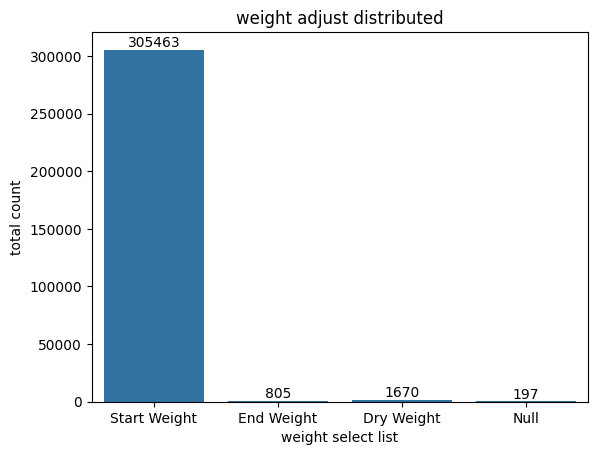

In [73]:
# 體重修正統計分佈圖：評估分母體重的來源體重比例和分佈
temp_null = np.unique(np.array(weight_select_df), return_counts = True)
print(temp_null)
x = ['Start Weight','End Weight','Dry Weight','Null']
h = temp_null[1]
sns.barplot(x=x, y=h)
for i in range(len(x)):
    plt.text(x=i, y=h[i]+1, s=str(h[i]), ha='center', va='bottom')
plt.xlabel('weight select list')
plt.ylabel('total count')
plt.title("weight adjust distributed")
plt.show()

### 新增分母體重修正實際脫水量

In [74]:
# 分母體重 處理成透析成體重
# 分母體重篩選流程：開始體重->結束體重->乾體重->9999
# 以體重差做評估: 處理合理範圍但實際邏輯不合理的數值，洗前(體重1開始)-洗後的差區間不符合-5~10kg
# 在任一體重或脫水量非9999情況之下評估abs(開始體重-乾體重)、abs(結束體重-乾體重)哪一個差最小
# 如(結束體重-乾體重)差最小，則以(結束體重+實際脫水)視為新的分母體重
# 根據體重差二次評估分母體重的可靠性
check_num = 0
for index, weight_row in tqdm(weight_check.iterrows()):
    if (-5<=weight_row['開始-結束體重']<=10) ==False and (weight_row['體重1開始']!=9999.0 and weight_row['體重結束']!=9999.0 and weight_row['體重實際脫水']!=9999.0):
        sd = abs(weight_row['體重1開始']-weight_row['體重2標準體重']) # 66 - 55 = 11
        ed = abs(weight_row['體重結束']-weight_row['體重2標準體重']) # 57 - 55 = 2
        if sd>ed:
            weight_check.loc[index,'分母體重'] = weight_row['體重實際脫水'] + weight_row['體重結束']
            check_num+=1
print(f"共修正{check_num}筆分母體重")
# 共修正2700筆分母體重

0it [00:00, ?it/s]

共修正2710筆分母體重


In [75]:
data_df[['體重1開始','體重2標準體重','體重結束','體重實際脫水','體重機器顯示','分母體重']] = weight_check[['體重1開始','體重2標準體重','體重結束','體重實際脫水','體重機器顯示','分母體重']]
print(f"分母體重共{len(data_df[data_df['分母體重']==9999.0])}筆異常資料")
data_df.describe()

分母體重共197筆異常資料


,FISTULA,GRAFT,DLC,PERMCATH,Catheter,K,HGB,HCT,RBC,WBC,Platelet,Creatinine,MCV,MCHC,MCH,Na,Ca,BUN,AST (SGOT),ALT (SGPT),Alk.phosphatase,Glucose AC,Glucose PC,ALBUMIN,P,TIBC,Ferritin,BUN (洗腎後),IRON/TIBC,Intact PTH,Iron,LDL Cholesterol,Bilirubin-T,Cholesterol-T,CRP,URR%,HBs,HBsAg,HBc,HCV,透析液 Ca,HBV,性別,age,體重1開始,體重2標準體重,體重結束,體重實際脫水,體重機器顯示,分母體重
count,308135.000000,308135.000000,308135.000000,308135.000000,308135.000000,308135.000000,308135.000000,308135.000000,308135.000000,308135.000000,308135.000000,308135.000000,308135.00000,308135.000000,308135.000000,308135.000000,308135.000000,308135.000000,308135.000000,308135.000000,308135.000000,308135.000000,308135.000000,308135.000000,308135.000000,308135.000000,308135.000000,308135.000000,308135.000000,308135.000000,308135.000000,308135.000000,308135.000000,308135.000000,308135.000000,308135.000000,308135.000000,308135.000000,308135.000000,308135.000000,308135.000000,308135.000000,308135.000000,308135.000000,308135.000000,308135.000000,308135.000000,308135.000000,308135.000000,308135.000000
mean,0.840044,0.130631,0.000844,0.066597,0.066747,6.768615,11.962481,35.559896,5.423779,7.829682,199.875954,11.119802,90.33713,34.258891,30.623225,139.555331,12.787893,73.139335,21.671345,17.272987,109.659941,151.843173,8983.535947,7.003210,9.530396,271.555406,407.054713,90.035530,64.514075,42.832865,100.341883,5851.280299,22.353580,180.951924,57.246146,762.695154,66.009629,61.726286,65.869979,67.418323,28.452107,61.726286,0.585273,62.436052,150.127658,178.603628,190.976153,127.250737,118.206815,70.163557
std,0.366566,0.336997,0.029036,0.249324,0.249583,153.818990,91.753251,124.437229,124.741624,112.431303,130.499021,89.998297,123.92023,124.384963,124.459941,155.911574,189.571927,174.437192,194.406902,151.849184,260.183579,144.359253,2982.393876,174.548433,215.253811,594.772869,671.784310,835.875058,605.496227,639.489813,603.773825,4888.743574,467.805317,476.223627,748.119353,2525.186238,805.682564,782.532440,804.081574,817.956554,504.535875,782.532440,0.492676,11.720412,921.238020,1072.899233,1127.159839,1110.706426,1069.912680,251.487335
min,0.000000,0.000000,0.000000,0.000000,0.000000,2.000000,3.700000,12.400000,1.330000,0.170000,7.000000,1.430000,56.70000,25.000000,17.900000,111.000000,4.100000,0.000000,5.000000,3.000000,20.000000,10.000000,34.000000,1.400000,0.300000,67.000000,5.920000,2.000000,4.200000,0.000000,7.000000,9.000000,0.100000,43.000000,0.000000,7.500000,0.000000,0.000000,0.000000,0.000000,2.500000,0.000000,0.000000,15.000000,0.000000,20.500000,20.100000,0.000000,0.000000,0.000000
25%,1.000000,0.000000,0.000000,0.000000,0.000000,3.900000,10.300000,31.500000,3.450000,5.100000,155.000000,8.800000,85.40000,32.000000,27.800000,135.000000,8.700000,58.000000,12.000000,9.000000,64.000000,99.000000,9999.000000,3.700000,3.900000,202.000000,180.000000,15.000000,20.100000,1.000000,45.000000,92.000000,0.300000,130.000000,0.140000,69.500000,0.000000,0.000000,1.000000,0.000000,2.500000,0.000000,0.000000,56.000000,54.900000,52.600000,52.700000,1.600000,1.700000,54.700000
50%,1.000000,0.000000,0.000000,0.000000,0.000000,4.400000,11.200000,34.100000,3.810000,6.300000,195.000000,10.230000,89.80000,32.700000,29.500000,137.000000,9.200000,69.000000,16.000000,12.000000,85.000000,129.000000,9999.000000,4.000000,4.800000,231.000000,322.400000,19.000000,25.800000,2.000000,59.000000,9999.000000,0.400000,153.000000,0.356000,73.100000,1.000000,0.000000,1.000000,0.000000,3.000000,0.000000,1.000000,63.000000,63.500000,61.000000,61.100000,2.200000,2.300000,63.100000
75%,1.000000,0.000000,0.000000,0.000000,0.000000,4.800000,12.000000,36.700000,4.210000,7.690000,235.000000,11.750000,93.60000,33.400000,31.000000,139.000000,9.700000,81.000000,20.000000,17.000000,117.000000,181.000000,9999.000000,4.200000,5.700000,263.000000,478.900000,23.000000,33.300000,2.000000,77.000000,9999.000000,0.500000,182.000000,0.866000,76.900000,1.000000,0.000000,1.000000,0.000000,3.500000,0.000000,1.000000,70.000000,71.900000,69.000000,6

In [76]:

# print(f"\n分母體重或是結束體重其中一項為異常值9999: 共計{weight_check[weight_check['開始-結束體重']==9999].shape[0]}筆")
# print(f"(開始體重-結束體重)不符合-5~10區間: 共計{weight_check[(weight_check['開始-結束體重']<-5)|(weight_check['開始-結束體重']>10)&(weight_check['開始-結束體重']!=9999)].shape[0]}筆\n")
# failed_water_df = weight_check[(weight_check['開始-結束體重']<-5)|(weight_check['開始-結束體重']>10)&(weight_check['開始-結束體重']!=9999)]
# failed_water_df.sample(30)
# weight_failed_patient_list = np.unique(failed_water_df['ID'].astype(str).values, return_counts=True)
# weight_failed_patient_list = pd.DataFrame({"ID":weight_failed_patient_list[0],"計數":weight_failed_patient_list[1]}).sort_values(by='計數', ascending=False)
# weight_failed_patient_list.reset_index(inplace=True, drop=True)
# print(weight_failed_patient_list)
# level = 0
# print(f"\nID: {weight_failed_patient_list.loc[level,'ID']} 共有{data_df[data_df['ID']==weight_failed_patient_list.loc[level,'ID']].shape[0]}筆紀錄")

In [77]:
if "第一階段處理結果-後半部檢驗資料[7-檢驗值確認結束]計算.csv" in os.listdir("./dataset/"):
    data_df = pd.read_csv("./dataset/第一階段處理結果-後半部檢驗資料[7-檢驗值確認結束]計算.csv")
else:
    data_df.to_csv("./dataset/第一階段處理結果-後半部檢驗資料[7-檢驗值確認結束]計算.csv", index=False, encoding='utf-8-sig')

### 二次修正每公斤脫水量

In [78]:
# 每公斤脫水量計算
weight_water = data_df[['分母體重', '體重實際脫水']]
kg_water = []
for idx, value in tqdm(weight_water.iterrows()):
    if (value['分母體重']!=9999 and value['體重實際脫水']!=9999):
        kg_water.append((value['體重實際脫水']*1000)/value['分母體重'])
    else:
        kg_water.append(9999.0)
weight_water['每公斤脫水量(ml/kg)'] = kg_water
data_df['每公斤脫水量(ml/kg)'] = weight_water['每公斤脫水量(ml/kg)']
print(f"每公斤脫水量共{len(data_df[data_df['每公斤脫水量(ml/kg)']==9999.0])}筆異常資料")
weight_water.describe()

0it [00:00, ?it/s]

每公斤脫水量共3856筆異常資料


,分母體重,體重實際脫水,每公斤脫水量(ml/kg)
count,308135.000000,308135.000000,308135.000000
mean,70.163557,127.250737,160.482293
std,251.487335,1110.706426,1107.630434
min,0.000000,0.000000,0.000000
25%,54.700000,1.600000,26.729560
50%,63.100000,2.200000,35.658915
75%,71.300000,2.900000,45.112782
max,9999.000000,9999.000000,9999.000000


In [79]:
if "第一階段處理結果-後半部檢驗資料[8-每公斤脫水量]計算.csv" in os.listdir("./dataset/"):
    data_df = pd.read_csv("./dataset/第一階段處理結果-後半部檢驗資料[8-每公斤脫水量]計算.csv")
else:
    data_df.to_csv("./dataset/第一階段處理結果-後半部檢驗資料[8-每公斤脫水量]計算.csv", index=False, encoding='utf-8-sig')

In [80]:
weight_list = data_df[['體重1開始', '體重2標準體重', '體重結束', '分母體重', '體重機器顯示', '體重實際脫水']]
# 體重評估
for cols in weight_list.columns:
    print(f"[[{cols }]]")
    weight__ = weight_list[cols].values
    weight__2 = weight__[weight__!=9999]
    if cols in ['體重1開始', '體重2標準體重', '體重結束', '分母體重']:
        weight__3 = weight__[(weight__<20)|(weight__>150)]
        print(f"異常筆數: {len(weight__3)}")
    else:
        weight__3 = weight__[(weight__<0.0)|(weight__>10)]
        print(f"異常筆數: {len(weight__3)}")
    # print(f"Null筆數: {len(weight__)-len(weight__2)}")
    # print(f"{cols } Min: {np.min(weight__2):.2f} Max: {np.max(weight__2):.2f} Mean: {np.mean(weight__2):.2f}")
    print(f"Min: {np.min(weight__2):.2f} Max: {np.max(weight__2):.2f}\n")
    # break
weight_list['驗證：開始-結束'] = weight_list['體重1開始']-weight_list['體重結束']
weight_list['驗證：開始8%'] = weight_list['體重1開始']*0.08
weight_list['驗證：開始-結束'] = weight_list['驗證：開始-結束'].apply(lambda x: 0.0 if x<0 else x)
print("共{}筆資料大於10公斤脫水量".format(weight_list['驗證：開始-結束'].apply(lambda x: 1 if x>10 else 0).sum()))
print("共{}筆資料大於8%基底體重脫水量".format(np.sum([weight_list['驗證：開始8%']<weight_list['驗證：開始-結束']])))

[[體重1開始]]
異常筆數: 2683
Min: 0.00 Max: 148.00

[[體重2標準體重]]
異常筆數: 3634
Min: 20.50 Max: 125.00

[[體重結束]]
異常筆數: 4016
Min: 20.10 Max: 146.00

[[分母體重]]
異常筆數: 208
Min: 0.00 Max: 127.30

[[體重機器顯示]]
異常筆數: 3571
Min: 0.00 Max: 10.00

[[體重實際脫水]]
異常筆數: 3852
Min: 0.00 Max: 8.50

共3852筆資料大於10公斤脫水量
共5468筆資料大於8%基底體重脫水量


# 增加糖尿病

In [81]:
#判斷有無糖尿病
OPD = pd.read_csv("./dataset/drug_lab_base_order/OPD_en_utf8.txt")
lab_df_Anti = lab_df_Anti[lab_df_Anti['檢驗名稱'] == 'HbA1c']
lab_df_Anti = lab_df_Anti[lab_df_Anti['DATANUM'] > '6.5']

In [82]:
# 新增一個表格df 判斷這個ID是不是有糖尿病
df =  pd.DataFrame({'ID':data_df['ID']})
df = df.drop_duplicates(keep='first', inplace=False)
df.index = range(len(df))

In [83]:
#初步用HbA1c是否大於6.5的資料判斷有沒有糖尿病
df['有無糖尿病值'] = np.nan
for i in range(len(df)): 
    name = df['ID'][i]
    feature_df = lab_df_Anti [lab_df_Anti ['ID'] == name]
    if len(feature_df) > 0:
        df['有無糖尿病值'][i] = 1
    else:
        df['有無糖尿病值'][i] = 0

In [84]:
OPD =  pd.DataFrame({'ID':OPD['ID'], 'CHOP1ICD1':OPD['CHOP1ICD1'], 'CHOP1ICD2':OPD['CHOP1ICD2'], 'CHOP1ICD3':OPD['CHOP1ICD3'], 'CHOP1ICD4':OPD['CHOP1ICD4'], 'CHOP1ICD5':OPD['CHOP1ICD5'], 'CHOP1ICD6':OPD['CHOP1ICD6']})
OPD = OPD.fillna('0')

In [85]:
#用診斷碼的資料判斷有沒有糖尿病
OPD['有無糖尿病診斷碼'] = np.nan
for i in range(len(OPD)):
    if ('250.' in OPD['CHOP1ICD1'][i]) | ('250.' in OPD['CHOP1ICD2'][i]) | ('250.' in OPD['CHOP1ICD3'][i])\
    | ('250.' in OPD['CHOP1ICD4'][i]) | ('250.' in OPD['CHOP1ICD5'][i]) | ('250.' in OPD['CHOP1ICD6'][i]):
        OPD['有無糖尿病診斷碼'][i] = 1
        
    elif ('357.2' in OPD['CHOP1ICD1'][i]) | ('357.2' in OPD['CHOP1ICD2'][i]) | ('357.2' in OPD['CHOP1ICD3'][i])\
    | ('357.2' in OPD['CHOP1ICD4'][i]) | ('357.2' in OPD['CHOP1ICD5'][i]) | ('357.2' in OPD['CHOP1ICD6'][i]):
        OPD['有無糖尿病診斷碼'][i] = 1
        
    elif ('326.0' in OPD['CHOP1ICD1'][i]) | ('326.0' in OPD['CHOP1ICD2'][i]) | ('326.0' in OPD['CHOP1ICD3'][i])\
    | ('326.0' in OPD['CHOP1ICD4'][i]) | ('326.0' in OPD['CHOP1ICD5'][i]) | ('326.0' in OPD['CHOP1ICD6'][i]):
        OPD['有無糖尿病診斷碼'][i] = 1
        
    elif ('362.07' in OPD['CHOP1ICD1'][i]) | ('362.07' in OPD['CHOP1ICD2'][i]) | ('362.07' in OPD['CHOP1ICD3'][i])\
    | ('362.07' in OPD['CHOP1ICD4'][i]) | ('362.07' in OPD['CHOP1ICD5'][i]) | ('362.07' in OPD['CHOP1ICD6'][i]):
        OPD['有無糖尿病診斷碼'][i] = 1
        
    else:
        OPD['有無糖尿病診斷碼'][i] = 0

In [86]:
OPD = pd.DataFrame({'ID':OPD['ID'], '有無糖尿病診斷碼':OPD['有無糖尿病診斷碼']})
OPD = OPD.drop_duplicates(keep='first', inplace=False)
OPD.index = range(len(OPD))
OPD_1 = pd.DataFrame(columns = ['ID', '有無糖尿病診斷碼'])

In [87]:
for i in set(OPD['ID']):
    O = OPD[OPD['ID'] == i]
    if len(O) == 1:
        new_list = [(i, O['有無糖尿病診斷碼'].values)]
    else:
        O1 = O[O['有無糖尿病診斷碼'] == 1]
        new_list = [(i, O1['有無糖尿病診斷碼'].values)]
    dfNew=pd.DataFrame(new_list, columns = ['ID' , '有無糖尿病診斷碼'])
    # OPD_1=OPD_1.append(dfNew,ignore_index=True)
    OPD_1 = pd.concat((OPD_1, dfNew))

In [88]:
OPD_1['有無糖尿病診斷碼0'] = OPD_1['有無糖尿病診斷碼'].apply(lambda x: ', '.join([str(i) for i in x]))
del(OPD_1['有無糖尿病診斷碼'])
OPD_1 = OPD_1.drop_duplicates(keep='first', inplace=False)
OPD_1.index = range(len(OPD_1))
df = pd.merge(df, OPD_1 , on=['ID'], how='left')

In [89]:
df['有無糖尿病'] = np.nan
for i in range(len(df)):
    if (df['有無糖尿病值'][i] == 1) | (df['有無糖尿病診斷碼0'][i] == '1.0'):
        df['有無糖尿病'][i] = 1
        
    else:
        df['有無糖尿病'][i] = 0
del(df['有無糖尿病診斷碼0'])
del(df['有無糖尿病值'])
# 將判斷好的ＩＤ是否有糖尿病按照ＩＤmerge到df裏
data_df = pd.merge(data_df, df, on=['ID'], how='left')

In [90]:
if "第一階段處理結果-後半部檢驗資料[9-糖尿病]計算.csv" in os.listdir("./dataset/"):
    data_df = pd.read_csv("./dataset/第一階段處理結果-後半部檢驗資料[9-糖尿病]計算.csv")
else:
    data_df.to_csv("./dataset/第一階段處理結果-後半部檢驗資料[9-糖尿病]計算.csv", index=False, encoding='utf-8-sig')

In [91]:
print(len(set(data_df['ID'])))

1051


# 第二階段處理
## 處理新的特徵、血壓、體溫、脈搏

In [92]:
# data_df['開始脈搏'].unique()

In [93]:
flist =['開始血壓SBP', '開始血壓DBP', '開始脈搏','體溫', '結束脈搏']
if "第二階段處理結果-生理數據[1-血壓脈搏粗布處裡]修正.csv" in os.listdir("./dataset/"):
    data_df = pd.read_csv("./dataset/第二階段處理結果-生理數據[1-血壓脈搏粗布處裡]修正.csv")
else:
    # 修正字串轉數字步驟
    flist =['開始血壓SBP', '開始血壓DBP', '開始脈搏','體溫', '結束脈搏']
    data_df[flist] = data_df[flist].astype(str) #防止後續處理小數點時出現浮點數錯誤
    for f in flist:
        print(f)
        for i in tqdm(range(len(data_df))):
            if not pd.isnull(data_df[f][i]):
                data_df.loc[i,f] = ''.join([x for idx, x in enumerate(data_df[f][i]) if x.isdigit() or x=='.' or x=='-' or x=='/']) 
    data_df.to_csv("./dataset/第二階段處理結果-生理數據[1-血壓脈搏粗布處裡]修正.csv", index=False, encoding='utf-8-sig')

開始血壓SBP


  0%|          | 0/308135 [00:00<?, ?it/s]

開始血壓DBP


  0%|          | 0/308135 [00:00<?, ?it/s]

開始脈搏


  0%|          | 0/308135 [00:00<?, ?it/s]

體溫


  0%|          | 0/308135 [00:00<?, ?it/s]

結束脈搏


  0%|          | 0/308135 [00:00<?, ?it/s]

In [94]:
# 30 <= Pulse <= 150 # 40 <= SBP <= 240 # 30 <= DBP <= 140
# *****2024.04.26修正：合理SBP範圍更新為60-240*****

In [95]:
# 初步字串轉數值
# 起初SBP血壓如果過低會多測量幾次
data_df[flist] = data_df[flist].astype(str) #防止後續處理小數點時出現浮點數錯誤
data_df['開始血壓SBP'] = data_df['開始血壓SBP'].apply(lambda x: x.replace("..",".") if ".." in x else x)
data_df['開始血壓SBP'].replace(['-','nan','Nan','',"--",],"9999.0", inplace=True)
# 將有範圍且符合血壓範圍的資料做平均補值, e.g: 83-106 => 94
data_df['開始血壓SBP'] = data_df['開始血壓SBP'].apply(lambda x: pulse_process(x, type_='sbp'))
for index, bp in (data_df[['ID','開始血壓SBP']].iterrows()):
    if str(bp['開始血壓SBP']).count('-') ==1:
        bp_split = str(bp['開始血壓SBP']).split('-')
        if bp_split[0]!='' and bp_split[-1]!='':
            # if (40 <= int(bp_split[0]) <= 240) and (40 <= int(bp_split[-1]) <= 240):
            if (60 <= int(bp_split[0]) <= 240) and (60 <= int(bp_split[-1]) <= 240):
                print(bp_split)
                data_df.loc[index,'開始血壓SBP'] = (int(bp_split[0])+int(bp_split[-1]))//2
            
data_df['開始血壓SBP'] = pd.to_numeric(data_df['開始血壓SBP'])

已經處理錯誤數值 B:(116/) A:(116/ => 116)

已經處理錯誤數值 B:(1/86) A:(1/86 => 186.0)

已經處理錯誤數值 B:(/179) A:(/179 => 179)

已經處理錯誤數值 B:(156/) A:(156/ => 156)

已經處理錯誤數值 B:(125/64) A:(125/64 => 125)

已經處理錯誤數值 B:(128/) A:(128/ => 128)

已經處理錯誤數值 B:(18/0) A:(18/0 => 180.0)

已經處理錯誤數值 B:(107/55) A:(107/55 => 107)

已經處理錯誤數值 B:(177/) A:(177/ => 177)

已經處理錯誤數值 B:(118/) A:(118/ => 118)

已經處理錯誤數值 B:(108/) A:(108/ => 108)

已經處理錯誤數值 B:(158/) A:(158/ => 158)



In [96]:
data_df['開始血壓DBP'] = data_df['開始血壓DBP'].apply(lambda x: x.replace("..",".") if ".." in x else x)
data_df['開始血壓DBP'].replace(['--','-','nan','Nan',''],"9999.0", inplace=True)
data_df['開始血壓DBP'] = data_df['開始血壓DBP'].apply(lambda x: pulse_process(x, type_='dbp'))
# 將有範圍且符合血壓範圍的資料做平均補值, e.g: 83-106 => 94
for index, bp in (data_df[['ID','開始血壓DBP']].iterrows()):
    if str(bp['開始血壓DBP']).count('-') >0:
        bp_split = str(bp['開始血壓DBP']).split('-')
        if bp_split[0]!='' and bp_split[-1]!='':
            if (30 <= int(bp_split[0]) <= 140) and (30 <= int(bp_split[-1]) <= 140):
                print(bp_split)
                data_df.loc[index,'開始血壓DBP'] = (int(bp_split[0])+int(bp_split[-1]))//2

data_df['開始血壓DBP'] = pd.to_numeric(data_df['開始血壓DBP'])

已經處理錯誤數值 B:(/80) A:(/80 => 80)

已經處理錯誤數值 B:(8/0) A:(8/0 => 80.0)

已經處理錯誤數值 B:(/83) A:(/83 => 83)

已經處理錯誤數值 B:(8/0) A:(8/0 => 80.0)

已經處理錯誤數值 B:(/47) A:(/47 => 47)

已經處理錯誤數值 B:(68/) A:(68/ => 68)

已經處理錯誤數值 B:(67/) A:(67/ => 67)

已經處理錯誤數值 B:(/82) A:(/82 => 82)

已經處理錯誤數值 B:(/80) A:(/80 => 80)

已經處理錯誤數值 B:(68/) A:(68/ => 68)



In [97]:
data_df['開始脈搏'] = data_df['開始脈搏'].apply(lambda x: x.replace("..",".") if ".." in x else x)
# data_df['開始脈搏'].replace(['--','-','nan','Nan','','.',"9-0","7-","8-","7-67","144-147"],"9999.0", inplace=True)
data_df['開始脈搏'].replace(['--','-','nan','Nan','','.'],"9999.0", inplace=True)
data_df['開始脈搏'] = data_df['開始脈搏'].apply(lambda x: pulse_process(x, type_='pulse'))
# data_df['開始脈搏'].replace(
#                           ["7-0","79-","68/","8/0","78/"]
#                          ,["70","79","68","80","78"]
#                          , inplace=True)
# 將有範圍且符合脈搏範圍的資料做平均補值, e.g: 83-106 => 94
for index, bp in (data_df[['ID','開始脈搏']].iterrows()):
    if str(bp['開始脈搏']).count('-') >0:
        bp_split = str(bp['開始脈搏']).split('-')
        if bp_split[0]!='' and bp_split[-1]!='':
            if (30 <= int(bp_split[0]) <= 150) and (30 <= int(bp_split[-1]) <= 150):
                print(bp_split,'-1')
                data_df.loc[index,'開始脈搏'] = (int(bp_split[0])+int(bp_split[-1]))//2
            elif (30 <= int(bp_split[0])) and (30 <= int(bp_split[-1])):
                print(bp_split,'-2')
                data_df.loc[index,'開始脈搏'] = min([int(bp_split[0]), int(bp_split[-1])])
            else:
                print(bp_split,'-3')
                data_df.loc[index,'開始脈搏'] = 9999

data_df['開始脈搏'] = pd.to_numeric(data_df['開始脈搏'])

已經處理錯誤數值 B:(68/) A:(68/ => 68)

已經處理錯誤數值 B:(8/0) A:(8/0 => 80.0)

已經處理錯誤數值 B:(78/) A:(78/ => 78)



In [98]:
# error處理: 脈搏範圍取平均 or 取左邊紀錄
# 正負20%為脈搏可接受的範圍
data_df['結束脈搏'] = data_df['結束脈搏'].apply(lambda x: x.replace("..",".") if ".." in x else x)
data_df['結束脈搏'].replace(['--','-','nan','Nan','','.'],"9999.0", inplace=True)
data_df['結束脈搏'] = data_df['結束脈搏'].apply(lambda x: pulse_process(x, type_='pulse'))
# data_df['結束脈搏'].replace(["79-","83-"],
#                         ["79","83"]
#                         , inplace=True)
# 將有範圍且符合脈搏範圍的資料做平均補值, e.g: 83-106 => 94
for index, bp in (data_df[['ID','結束脈搏']].iterrows()):
    if str(bp['結束脈搏']).count('-') >0:
        bp_split = str(bp['結束脈搏']).split('-')
        if bp_split[0]!='' and bp_split[-1]!='':
            if (30 <= int(bp_split[0]) <= 150) and (30 <= int(bp_split[-1]) <= 150):
                print(bp_split,'-1')
                data_df.loc[index,'結束脈搏'] = (int(bp_split[0])+int(bp_split[-1]))//2
            elif (30 <= int(bp_split[0])) and (30 <= int(bp_split[-1])):
                print(bp_split,'-2')
                data_df.loc[index,'結束脈搏'] = min([int(bp_split[0]), int(bp_split[-1])])
            else:
                print(bp_split,'-3')
                data_df.loc[index,'結束脈搏'] = 9999
                
# data_df['結束脈搏'].replace(["94-100","108-125","130-140","85-130","105-130","131-139","128-136","80-150","145-158","140-166"],'9999.0', inplace=True)

data_df['結束脈搏'] = pd.to_numeric(data_df['結束脈搏'])

In [99]:
# 將nan、無數字欄位視為無紀錄，標記為0
data_df['體溫'] = data_df['體溫'].astype(str)
data_df['體溫'].replace(['--','-','nan','Nan','',' ','.'] ,"9999"
                       , inplace=True)

# data_df['體溫'].replace(["1.60.3/1.9","1.9/2.0","0.3/3.1","1.0/1.1","/0.5/1.8"]
# #                        ,"9999.0", inplace=True)
# data_df['體溫'] = data_df['體溫'].apply(lambda x: x.replace("..",".") if ".." in x else x)
# data_df['體溫'] = data_df['體溫'].apply(lambda x: x[0:-1] if x[-1]=='.' else x)
# data_df['體溫'] = data_df['體溫'].apply(lambda x: x[1::] if x[0]=='.' else x)
data_df['體溫'] = data_df['體溫'].apply(lambda x: temperature_process(x, type_='temp'))
# data_df['體溫'].replace([".5.5","3.20.3",'1.60.31.9','1.92.0','0.33.1','0.31.8',"1.01.1","0.51.8"],'9999.0', inplace=True)
# data_df['體溫'].replace(["38-37.3","37.6-37.1","37.837.3","37.136.4","38-37","37.5-36.2","37.538.6","37.6-36.3","36.466.8","38.137.1","36.736.7","37.536.7","38.137.3"],
#                         ["38","37.6","37.8","37.1","37.5","37.5","37.5","36.3","36.4","37.1","36.7","36.7","37.3"]
#                         , inplace=True)
# data_df['體溫'].replace(["3.6.2","3.6.4","3.6.9","3.6.3","3.5.7","3.6.5","3.5.9","3.5.5","3.6.1","3.6.6","3.5.8","３５６","３６３"],
#                         ["36.2","36.4","36.9","36.3","35.7","36.5","35.9","35.5","36.1","36.6","35.8","35.6","36.3"]
#                         , inplace=True)
# data_df['體溫'].replace(["35./","35.-2","360.3/3.2","35.5.4","35.3/","36-","35.3-","35.2.1"],
#                         ["35","35.2","36","35.5","35.3","36","35.3","35.2"]
#                         , inplace=True)

data_df['體溫'] = pd.to_numeric(data_df['體溫'])

# 體溫合理範圍 32-40
print("***修正前***")
print(data_df.shape)
print(f"小於32度共計：{data_df[(data_df['體溫']<32)&(data_df['體溫']!=9999)&(data_df['體溫']!=0)].shape[0]}筆")
print(f"大於40度共計：{data_df[(data_df['體溫']>40)&(data_df['體溫']!=9999)&(data_df['體溫']!=0)].shape[0]}筆")
print(f"無紀錄共計：{data_df[(data_df['體溫']==0)].shape[0]}筆")
print(f"異常資料共計：{data_df[data_df['體溫']==9999].shape[0]}筆")
data_df['體溫'] = data_df['體溫'].apply(lambda x: 9999.0 if x<32 and x!=0 else x)
data_df['體溫'] = data_df['體溫'].apply(lambda x: 9999.0 if x>40 and x!=0 else x)
print("***修正後***")
print(f"小於32度共計：{data_df[(data_df['體溫']<32)&(data_df['體溫']!=9999)&(data_df['體溫']!=0)].shape[0]}筆")
print(f"大於40度共計：{data_df[(data_df['體溫']>40)&(data_df['體溫']!=9999)&(data_df['體溫']!=0)].shape[0]}筆")
print(f"無紀錄共計：{data_df[(data_df['體溫']==0)].shape[0]}筆")
print(f"異常資料共計：{data_df[data_df['體溫']==9999].shape[0]}筆")
# *****修正體溫資料型態2024.04.26: 體溫修正為類別變數：>=38(1.發燒), <38(0.正常), 9999視為正常體溫*****
data_df['體溫'] = data_df['體溫'].apply(lambda x: 1 if (x>=38) and (x!=9999) else 0)
print(data_df.shape)

已經處理錯誤數值 B:(337) A:(337 => 33.7)

已經處理錯誤數值 B:(374) A:(374 => 37.4)

已經處理錯誤數值 B:(352) A:(352 => 35.2)

已經處理錯誤數值 B:(362) A:(362 => 36.2)

已經處理錯誤數值 B:(365) A:(365 => 36.5)

已經處理錯誤數值 B:(361) A:(361 => 36.1)

已經處理錯誤數值 B:(354) A:(354 => 35.4)

已經處理錯誤數值 B:(38-37.3) A:(38-37.3 => 37.65)

已經處理錯誤數值 B:(351) A:(351 => 35.1)

已經處理錯誤數值 B:(351) A:(351 => 35.1)

已經處理錯誤數值 B:(-36) A:(-36 => 36)

已經處理錯誤數值 B:(365) A:(365 => 36.5)

已經處理錯誤數值 B:(355) A:(355 => 35.5)

已經處理錯誤數值 B:(374) A:(374 => 37.4)

已經處理錯誤數值 B:(3.6.3) A:(3.6.3 => 36.3)

已經處理錯誤數值 B:(367) A:(367 => 36.7)

已經處理錯誤數值 B:(364) A:(364 => 36.4)

已經處理錯誤數值 B:(362) A:(362 => 36.2)

已經處理錯誤數值 B:(363) A:(363 => 36.3)

已經處理錯誤數值 B:(3.5.7) A:(3.5.7 => 35.7)

已經處理錯誤數值 B:(3.6.5) A:(3.6.5 => 36.5)

已經處理錯誤數值 B:(362) A:(362 => 36.2)

已經處理錯誤數值 B:(361) A:(361 => 36.1)

已經處理錯誤數值 B:(362) A:(362 => 36.2)

已經處理錯誤數值 B:(368) A:(368 => 36.8)

已經處理錯誤數值 B:(363) A:(363 => 36.3)

已經處理錯誤數值 B:(362) A:(362 => 36.2)

已經處理錯誤數值 B:(-36) A:(-36 => 36)

已經處理錯誤數值 B:(367) A:(367 => 36.7

In [100]:
# 修正outlier 開始脈搏
# 定義脈搏?
# data_df['開始脈搏'] = data_df['開始脈搏'].astype(str)
# data_df['開始脈搏'].replace(['--','-','nan','Nan','','.',"9-","8-"],"9999.0", inplace=True)
data_df['開始脈搏'] = pd.to_numeric(data_df['開始脈搏'])
# data_df['開始脈搏'].replace(
#                           [153. ,   154. ,   161. ,   165. ,   172. ,   176. ,   177. ,  185. ,   189. ,   272. ,   276. ,   381. ,   479. ,   480. ,
#                            562. ,   567. ,   574. ,   575. ,   585. ,   590. ,   600. ,  623. ,   638. ,   645. ,   647. ,   654. ,   665. ,   666. ,
#                            668. ,   674. ,   678. ,   680. ,   684. ,   687. ,   690. ,  694. ,   700. ,   701. ,   702. ,   705. ,   707. ,   709. ,
#                            710. ,   714. ,   723. ,   725. ,   732. ,   733. ,   737. ,  738. ,   741. ,   743. ,   745. ,   746. ,   748. ,   749. ,
#                            756. ,   758. ,   765. ,   767. ,   769. ,   770. ,   772. ,  774. ,   776. ,   777. ,   778. ,   780. ,   781. ,   785. ,
#                            786. ,   789. ,   790. ,   794. ,   801. ,   810. ,   822. ,  832. ,   833. ,   836. ,   850. ,   856. ,   860. ,   863. ,
#                            867. ,   868. ,   869. ,   870. ,   872. ,   878. ,   883. ,  886. ,   887. ,   888. ,   890. ,   892. ,   894. ,   900. ,
#                            901. ,   914. ,   921. ,   936. ,   947. ,   959. ,   965. ,  974. ,   978. ,   984. ,   989. ,   998. ,  1000. ,  1014. ,
#                            1025. ,  1065. ,  1103. ,  5693. ,  6374. ,  6436. ,  6671. , 6779. ,  6936.1,  7278. ,  8016. ,  8364.4,  8735. ,  8887. ,
#                            8978. ,  9181. ,  9999. , 10006. , 69975. , 78124. ]
#                           ,9999.0
#                           ,inplace=True)

data_df['開始脈搏'] = data_df['開始脈搏'].apply(lambda x: 9999.0 if x<30 else x)
print(f"開始脈搏: 異常共{data_df[(data_df['開始脈搏']==9999)].shape[0]}筆")
# np.sort(np.unique(data_df[data_df['開始脈搏']>150]['開始脈搏'].astype(float).values))
# np.sort(np.unique(data_df[data_df['開始脈搏']<30]['開始脈搏'].astype(float).values))
# 把有小數點最後一位不是0的資料全抓出來轉成9999

data_df['開始脈搏'] = data_df['開始脈搏'].apply(lambda x: x if 30 <= x <= 150 else 9999.0)
data_df['開始脈搏'] = data_df['開始脈搏'].apply(lambda x: x if str(x)[-1] in ['0', '.'] else 9999.0)
print(f"開始脈搏: 異常共{data_df[(data_df['開始脈搏']==9999)].shape[0]}筆")

開始脈搏: 異常共4470筆
開始脈搏: 異常共4647筆


In [101]:
# 修正outlier 結束脈搏
# error list: 406.0, 623.0 1403
data_df['結束脈搏'] = pd.to_numeric(data_df['結束脈搏'])
data_df['結束脈搏'].replace(
                          [ 151. ,  153. ,  157. ,  158. ,  160. ,  162. ,  165. ,  168. ,  171. ,  174. ,  178. ,  180. ,  186. ,  191. ,  195. ,  223. ,
                            261. ,  266. ,  360. ,  373. ,  390. ,  406. ,  462. ,  477. ,  562. ,  575. ,  589. ,  623. ,  654. ,  656. ,  660. ,  667. ,
                            677. ,  684. ,  686. ,  687. ,  689. ,  696. ,  697. ,  701. ,  702. ,  708. ,  714. ,  723. ,  738. ,  740. ,  752. ,  754. ,
                            756. ,  758. ,  767. ,  768. ,  769. ,  788. ,  789. ,  790. ,  796. ,  800. ,  801. ,  802. ,  810. ,  811. ,  814. ,  817. ,
                            823. ,  834. ,  836. ,  841. ,  856. ,  863. ,  866. ,  867. ,  869. ,  881. ,  888. ,  891. ,  892. ,  898. ,  900. ,  901. ,
                            910. ,  911. ,  914. ,  920. ,  923. ,  925. ,  928. ,  932. ,  936. ,  964. ,  973. ,  985. ,  990. ,  995. ,  998. , 1001. ,
                            1010. , 1036. , 1041. , 1065. , 1113. , 1117. , 1403. , 6353.2,  6363. , 6463. , 6739.9, 6760.2, 7165.1, 7357.8, 7552.3, 7849. ,
                            7979. , 8356. , 8555.6, 8638.8, 9050. , 9999. ]
                          ,9999.0
                          ,inplace=True)
data_df['結束脈搏'] = data_df['結束脈搏'].apply(lambda x: 9999.0 if x<30 else x)
print(f"結束脈搏: 異常共{data_df[(data_df['結束脈搏']==9999)].shape[0]}筆")
# np.sort(np.unique(data_df[data_df['結束脈搏']>150]['結束脈搏'].astype(float).values))
# np.sort(np.unique(data_df[data_df['結束脈搏']<30]['結束脈搏'].astype(float).values))
# 把有小數點最後一位不是0的資料全抓出來轉成9999
data_df['結束脈搏'] = data_df['結束脈搏'].apply(lambda x: x if 30 <= x <= 150 else 9999.0)
data_df['結束脈搏'] = data_df['結束脈搏'].apply(lambda x: x if str(x)[-1] in ['0', '.'] else 9999.0)
print(f"結束脈搏: 異常共{data_df[(data_df['結束脈搏']==9999)].shape[0]}筆")

結束脈搏: 異常共4599筆
結束脈搏: 異常共4639筆


In [102]:
if "第二階段處理結果-生理數據[2-修正處理].csv" in os.listdir("./dataset/"):
    data_df = pd.read_csv("./dataset/第二階段處理結果-生理數據[2-修正處理].csv")
else:
    data_df.to_csv("./dataset/第二階段處理結果-生理數據[2-修正處理].csv", index=False, encoding='utf-8-sig')

In [103]:
#添加原始index，用於追蹤後續資料用
data_df.insert(0, 'Raw Index', list(data_df.index)) 

# 處理IntraHD資料 - 修正原始血壓異常值

In [4]:
# loading intraHD 
# 處理intraHD血壓
# intra_df = pd.read_csv("./dataset/drug_lab_base_order/intraHD2016_20_en.csv") old
intra_df_1 = pd.read_csv('./dataset/drug_lab_base_order/intraHD2016_18_utf8.txt')
intra_df_2 = pd.read_csv('./dataset/drug_lab_base_order/intraHD2019_20_utf8.txt')
intra_df = pd.concat([intra_df_1, intra_df_2])
del intra_df_1, intra_df_2
intra_df['洗腎紀錄時間']= pd.to_datetime(intra_df['洗腎紀錄時間'])
intra_df['洗腎紀錄時間去時分']= intra_df['洗腎紀錄時間']
intra_df['中記錄時間']= pd.to_datetime(intra_df['中記錄時間'])
intra_df['洗腎紀錄時間去時分']= intra_df['洗腎紀錄時間去時分'].dt.date

In [5]:
intra_df['血壓'] = intra_df['血壓'].apply(lambda x: x[1::].replace('.','/') if x[0]=='/' and '.' in x else x) # e.g: /144.62
intra_df['血壓'] = intra_df['血壓'].apply(lambda x: x[1::].replace('/.','/').replace('./','/') if '/.' in x or './' in x else x) # e.g: 144./62、144/.62
intra_df['血壓'] = intra_df['血壓'].apply(lambda x: x.replace('.','') if '.' in x else x) # e.g 14.3/84、.109/59、123/63.
#當前資料狀況基本上血壓都會有/作為區分sbp/dbp，以下為異常資料清單
# 'May-81', 'Dec-54', 'Jun-97', 'May-95', '14      ', '10月26日', 'Jun-96', 'Jun-93', 'May-94', 'Mar-72', 'May-78', 'Apr-72', 'Apr-69', 'Apr-83', 'May-99', 'Sep-99', '9月20日', '2月19日', 'May-95', 'Apr-93', 'May-90', 'May-84', 'Mar-91', 'Jun-97', '7月17日', 'May-86', 'Nov-95', 'Jun-96', '9月13日', 'May-95', 'Jul-89', 'May-88', 'May-96', 'May-86', 'Mar-68', 'Apr-96', '5月16日', '1.7', 'Jun-95', '11月3日', '11月6日', 'Nov-69', 'May-95', 'Apr-58', '-1.771428571', '-1.771428571', 'Jun-92', '10月10日', '10月10日', 'Apr-89', 'Apr-97', 'Mar-96', '1月1日', '1月1日', '1月1日', '-2', '1月1日', 'May-90', '1.638554217', 'Jun-97', '1月1日', '1月1日', '1月1日', '1月1日', '1月1日', '1月1日', 'Nov-49', '7月3日', 'Oct-86', 'Feb-73', '12月29日', 'Mar-75', '1月2日', '1月1日', '1月1日', '11月11日', '2月2日'
intra_df['血壓'] = intra_df['血壓'].apply(lambda x: re.sub(r'[^0-9\/]', '', x))
intra_df['血壓'] = intra_df['血壓'].apply(lambda x: '9999/9999' if '/' not in x else x)
intra_df['血壓'] = intra_df['血壓'].apply(lambda x: '9999/9999' if x=='/' else x)

In [6]:
sbp_list, dbp_list = [], []
for i in intra_df['血壓']:
    bp = i.split('/')
    if len(bp)==2: #有些紀錄有三筆數字。 e.g: 144/44/65
        sbp_list.append(bp[0]); dbp_list.append(bp[1])
    else:
        sbp_list.append(9999); dbp_list.append(9999)
intra_df['sbp'],intra_df['dbp'] = sbp_list, dbp_list
intra_df['sbp'],intra_df['dbp'] = pd.to_numeric(intra_df['sbp']), pd.to_numeric(intra_df['dbp'])
intra_df.to_csv('./dataset/drug_lab_base_order/intraHD2016_20_fix_2024-04-29.csv', encoding='utf-8-sig', index=False)

### 粗布處理血壓異常範圍

In [7]:
# loading intraHD 
intra_df = pd.read_csv("./dataset/drug_lab_base_order/intraHD2016_20_fix_2024-04-29.csv")
intra_df['洗腎紀錄時間']= pd.to_datetime(intra_df['洗腎紀錄時間'])
intra_df['洗腎紀錄時間去時分']= intra_df['洗腎紀錄時間']
intra_df['中記錄時間']= pd.to_datetime(intra_df['中記錄時間'])
intra_df['洗腎紀錄時間去時分']= intra_df['洗腎紀錄時間去時分'].dt.date
intra_df[intra_df['急診門診住院']=='2.門診  ']
data_df['洗腎紀錄時間去時分']= pd.to_datetime(data_df['洗腎紀錄時間去時分']).dt.date

In [ ]:
# 修正outlier 開始血壓SBP、DBP
# 40 <= SBP <= 240 # 30 <= DBP <= 140
# *****2024.04.26修正：合理SBP範圍更新為60-240*****
# data_df['開始血壓SBP'] = data_df['開始血壓SBP'].apply(lambda x: 9999.0 if x>240 or x <40 else x)
data_df['開始血壓SBP'] = data_df['開始血壓SBP'].apply(lambda x: 9999.0 if x>240 or x <60 else x)
data_df['開始血壓DBP'] = data_df['開始血壓DBP'].apply(lambda x: 9999.0 if x>140 or x <30 else x)
for cols in ['開始血壓DBP','開始血壓SBP']:
    temp_ = data_df[data_df[cols]!=9999][cols]
    print(f"Max:{float(min(temp_))} \t Min:{float(max(temp_))}\t- {cols}")

# error_startSBP = data_df[((data_df['開始血壓SBP']>240)|(data_df['開始血壓SBP']<40))][['ID','洗腎紀錄時間','洗腎紀錄時間去時分','開始血壓SBP']]
error_startSBP = data_df[((data_df['開始血壓SBP']>240)|(data_df['開始血壓SBP']<60))][['ID','洗腎紀錄時間','洗腎紀錄時間去時分','開始血壓SBP']]
print(f"共計{error_startSBP.shape[0]}筆錯誤SBP")

error_startDBP = data_df[((data_df['開始血壓DBP']>140)|(data_df['開始血壓DBP']<30))][['ID','洗腎紀錄時間','洗腎紀錄時間去時分','開始血壓DBP']]
print(f"共計{error_startDBP.shape[0]}筆錯誤DBP")

for index, error_row in tqdm(error_startSBP.iterrows()):
    match_intra_df = intra_df[(intra_df['ID']==error_row['ID'])&(intra_df['洗腎紀錄時間去時分']==error_row['洗腎紀錄時間去時分'])]
    match_intra_df = match_intra_df.sort_values('中記錄時間')
    if len(match_intra_df)!=0:
        intra_first_bp = match_intra_df.loc[match_intra_df.index[0]]['sbp']
        # if 40 <= intra_first_bp <= 240:
        if 60 <= intra_first_bp <= 240:
            error_startSBP.loc[index,'開始血壓SBP'] = intra_first_bp
        else:
            error_startSBP.loc[index,'開始血壓SBP'] = 9999.0
    else:
        error_startSBP.loc[index,'開始血壓SBP'] = 9999.0
data_df.update(error_startSBP)
print(f"共計{data_df[data_df['開始血壓SBP']==9999].shape[0]}筆錯誤SBP")

for index, error_row in tqdm(error_startDBP.iterrows()):
    match_intra_df = intra_df[(intra_df['ID']==error_row['ID'])&(intra_df['洗腎紀錄時間去時分']==error_row['洗腎紀錄時間去時分'])]
    match_intra_df = match_intra_df.sort_values('中記錄時間')
    if len(match_intra_df)!=0:
        intra_first_bp = match_intra_df.loc[match_intra_df.index[0]]['dbp']
        if 30 <= intra_first_bp <= 140:
            error_startDBP.loc[index,'開始血壓DBP'] = intra_first_bp
        else:
            error_startDBP.loc[index,'開始血壓DBP'] = 9999.0
    else:
        error_startDBP.loc[index,'開始血壓DBP'] = 9999.0
data_df.update(error_startDBP)
print(f"共計{data_df[data_df['開始血壓DBP']==9999].shape[0]}筆錯誤DBP")

Max:30.0 	 Min:140.0	- 開始血壓DBP
Max:60.0 	 Min:240.0	- 開始血壓SBP
共計3003筆錯誤SBP
共計2826筆錯誤DBP


0it [00:00, ?it/s]

共計802筆錯誤SBP


0it [00:00, ?it/s]

共計738筆錯誤DBP


In [10]:
if "第二階段處理結果-生理數據[3-血壓補值處裡].csv" in os.listdir("./dataset/"):
    data_df = pd.read_csv("./dataset/第二階段處理結果-生理數據[3-血壓補值處裡].csv")
else:
    data_df.to_csv("./dataset/第二階段處理結果-生理數據[3-血壓補值處裡].csv", index=False, encoding='utf-8-sig')

### 粗布處理脈搏異常範圍

In [11]:
# loading intraHD
intra_df = pd.read_csv("./dataset/drug_lab_base_order/intraHD2016_20_fix_2024-04-29.csv")
intra_df['洗腎紀錄時間']= pd.to_datetime(intra_df['洗腎紀錄時間'])
intra_df['洗腎紀錄時間去時分']= intra_df['洗腎紀錄時間']
intra_df['中記錄時間']= pd.to_datetime(intra_df['中記錄時間'])
intra_df['洗腎紀錄時間去時分']= intra_df['洗腎紀錄時間去時分'].dt.date
intra_df[intra_df['急診門診住院']=='2.門診  ']
data_df['洗腎紀錄時間去時分']= pd.to_datetime(data_df['洗腎紀錄時間去時分']).dt.date

In [12]:
# 修正outlier 開始/結束脈搏
# 30 <= Pulse <= 150
# 第一階段開始脈搏或結束脈搏補值：從IntraHD取第一筆或最後一筆脈搏補值
print(f"開始脈搏S: 異常共{data_df[(data_df['開始脈搏']==9999)].shape[0]}筆")
print(f"結束脈搏S: 異常共{data_df[(data_df['結束脈搏']==9999)].shape[0]}筆")
error_pulse = data_df[((data_df['開始脈搏']==9999)|(data_df['結束脈搏']==9999))][['ID','洗腎紀錄時間','洗腎紀錄時間去時分','開始脈搏','結束脈搏']]
for index, single_row in tqdm(error_pulse.iterrows()):
    if single_row['開始脈搏']==9999:
        match_intra_df = intra_df[(intra_df['ID']==single_row['ID'])&(intra_df['洗腎紀錄時間去時分']==single_row['洗腎紀錄時間去時分'])]
        if match_intra_df.shape[0]!=0:
            match_intra_df = match_intra_df.sort_values('中記錄時間')
            intra_first_bp = match_intra_df.loc[match_intra_df.index[0]]['脈搏']
            try:
                intra_first_bp = int(intra_first_bp)
            except:
                intra_first_bp = 9999
            if 30 <= intra_first_bp <= 150:
                error_pulse.loc[index,'開始脈搏'] = intra_first_bp
            else:
                error_pulse.loc[index,'開始脈搏'] = 9999.0
        else:
            error_pulse.loc[index,'開始脈搏'] = 9999.0
            
    if single_row['結束脈搏']==9999:
        match_intra_df = intra_df[(intra_df['ID']==single_row['ID'])&(intra_df['洗腎紀錄時間去時分']==single_row['洗腎紀錄時間去時分'])]
        if match_intra_df.shape[0]!=0:
            match_intra_df = match_intra_df.sort_values('中記錄時間')
            intra_first_bp = match_intra_df.loc[match_intra_df.index[-1]]['脈搏']
            try:
                intra_first_bp = int(intra_first_bp)
            except:
                intra_first_bp = 9999
            if 30 <= intra_first_bp <= 150:
                error_pulse.loc[index,'結束脈搏'] = intra_first_bp
            else:
                error_pulse.loc[index,'結束脈搏'] = 9999.0
        else:
            error_pulse.loc[index,'結束脈搏'] = 9999.0
            
print(f"開始脈搏E: 異常共{error_pulse[(error_pulse['開始脈搏']==9999)].shape[0]}筆")
print(f"結束脈搏E: 異常共{error_pulse[(error_pulse['結束脈搏']==9999)].shape[0]}筆")
data_df.update(error_pulse)

開始脈搏S: 異常共4647筆
結束脈搏S: 異常共4639筆


0it [00:00, ?it/s]

開始脈搏E: 異常共748筆
結束脈搏E: 異常共1008筆


In [13]:
if "第二階段處理結果-生理數據[4-脈搏補值處理].csv" in os.listdir("./dataset/"):
    data_df = pd.read_csv("./dataset/第二階段處理結果-生理數據[4-脈搏補值處理].csv")
else:
    # intra_df[(intra_df['ID']=='134811545')&(intra_df['洗腎紀錄時間']>'2020-8')&(intra_df['洗腎紀錄時間']<'2020-11')]
    error_pulse.to_csv("./dataset/outlier/第二階段處理結果-脈搏補值處理outlier_error.csv", index=False, encoding='utf-8-sig')
    data_df.to_csv("./dataset/第二階段處理結果-生理數據[4-脈搏補值處理].csv", index=False, encoding='utf-8-sig')

In [14]:
# loading intraHD
intra_df = pd.read_csv("./dataset/drug_lab_base_order/intraHD2016_20_fix_2024-04-29.csv")
intra_df['洗腎紀錄時間']= pd.to_datetime(intra_df['洗腎紀錄時間'])
intra_df['洗腎紀錄時間去時分']= intra_df['洗腎紀錄時間']
intra_df['中記錄時間']= pd.to_datetime(intra_df['中記錄時間'])
intra_df['洗腎紀錄時間去時分']= intra_df['洗腎紀錄時間去時分'].dt.date
intra_df[intra_df['急診門診住院']=='2.門診  ']

data_df['洗腎紀錄時間去時分']= pd.to_datetime(data_df['洗腎紀錄時間去時分']).dt.date

In [15]:
# 處理intraHD脈搏
intra_df['脈搏'] = intra_df['脈搏'].astype(str)
intra_df['脈搏'] = intra_df['脈搏'].apply(lambda x: re.sub(r'[^0-9\.-]', '', x))
# 將有範圍且符合脈搏範圍的資料做平均補值, e.g: 83-106 => 94
for index, bp in (intra_df[['ID','脈搏']].iterrows()):
    if str(bp['脈搏']).count('-') >0:
        bp_split = str(bp['脈搏']).split('-')
        if bp_split[0]!='' and bp_split[-1]!='':
            if (30 <= int(bp_split[0]) <= 150) and (30 <= int(bp_split[-1]) <= 150):
                # print(bp_split,'-1',index)
                intra_df.loc[index,'脈搏'] = (int(bp_split[0])+int(bp_split[-1]))//2
            elif (30 <= int(bp_split[0])) and (30 <= int(bp_split[-1])):
                # print(bp_split,'-2',index)
                intra_df.loc[index,'脈搏'] = min([int(bp_split[0]), int(bp_split[-1])])
            else:
                # print(bp_split,'-3',index)
                intra_df.loc[index,'脈搏'] =9999

In [16]:
intra_df['脈搏'] = pd.to_numeric(intra_df['脈搏'], errors='coerce')
intra_df['脈搏'] = intra_df['脈搏'].apply(lambda x: 9999.0 if x<30 else x)
intra_df['脈搏'] = intra_df['脈搏'].apply(lambda x: 9999.0 if x>150 else x)
intra_df['脈搏'].replace(np.nan, 9999, inplace=True)
print(intra_df.shape)
# intra_df = intra_df[intra_df['脈搏']!=9999] #過濾異常資料
print(intra_df.shape)

(1941900, 22)
(1941900, 22)


In [17]:
# 第二階段開始脈搏或結束脈搏檢測：從IntraHD取第一筆或最後一筆脈搏補值
# 規則："PH開始-IH第一筆" 或是 "PH開始-IH第二筆"的差>30，則代表任一次脈搏紀錄有問題
# 排除intra脈搏一開始就記錯的rows：異常標記9999 or nan
# e.g: P:130, I1:90, I2:120，嘗試取IntraHD-1: 90為主要開始脈搏
# 以60-100之間的為主，如果不在區間內取最接近60-100的脈搏
# 開始脈搏
filter_data_df = data_df[data_df['開始脈搏']!=9999]#排除開始脈搏已經為異常的數值
filter_data_df = filter_data_df[['Raw Index', 'ID','洗腎紀錄時間去時分','開始脈搏','結束脈搏']]
filter_intra_df = intra_df[['ID','洗腎紀錄時間去時分','中記錄時間','脈搏']]
merged_df = pd.merge(filter_data_df, filter_intra_df, on=['ID', '洗腎紀錄時間去時分'], how='inner')
merged_df = merged_df.sort_values(by=['ID','洗腎紀錄時間去時分','中記錄時間',], ascending=True)
merged_df['脈搏'] = pd.to_numeric(merged_df['脈搏'], errors='coerce')
merged_df['開始脈搏差'] = abs(merged_df['開始脈搏']-merged_df['脈搏'])
merged_df['開始脈搏差'].replace(np.nan, 9999, inplace=True)
grouped = merged_df.groupby(['ID', '洗腎紀錄時間去時分'])

In [18]:
cant_adjust_group_S = []
pulse_adjust_index_S = []
avg = (100+60)//2
for group_name, group_data in tqdm(grouped):
    if group_data.shape[0]>=2:
        first_pulse_diff = group_data.loc[group_data.index[0]]['開始脈搏差']
        second_pulse_diff = group_data.loc[group_data.index[1]]['開始脈搏差']
        if (first_pulse_diff>30 or second_pulse_diff>30):
            start_pulse = group_data.loc[group_data.index[0],'開始脈搏']
            first_pulse = group_data.loc[group_data.index[0],'脈搏']
            second_pulse = group_data.loc[group_data.index[1],'脈搏']
            if 60<=start_pulse<=100:
                data_df.loc[group_data['Raw Index'].iloc[0], '開始脈搏'] = start_pulse
                
                # pulse_adjust_index_S.append(group_data.iloc[0]['Raw Index'])
            elif 60<=first_pulse<=100:
                data_df.loc[group_data['Raw Index'].iloc[0], '開始脈搏'] = first_pulse
                
                pulse_adjust_index_S.append(group_data.iloc[0]['Raw Index'])
            elif 60<=second_pulse<=100:
                data_df.loc[group_data['Raw Index'].iloc[0], '開始脈搏'] = second_pulse
                
                pulse_adjust_index_S.append(group_data.iloc[0]['Raw Index'])
            else:
                pluse_list = [start_pulse, first_pulse, second_pulse]
                min_pluse = pluse_list[np.argmin([abs(avg-start_pulse),abs(avg-first_pulse),abs(avg-second_pulse)])]
                if min_pluse>9000:
                    data_df.loc[group_data['Raw Index'].iloc[0], '開始脈搏'] = start_pulse
                else:
                    data_df.loc[group_data['Raw Index'].iloc[0], '開始脈搏'] = min_pluse
                    pulse_adjust_index_S.append(group_data.iloc[0]['Raw Index'])       
    else:
        cant_adjust_group_S.append(group_name)
    # break
print(f"共調整{len(pulse_adjust_index_S)}，無法調整資料共{len(cant_adjust_group_S)}")

  0%|          | 0/267863 [00:00<?, ?it/s]

共調整2260，無法調整資料共25


In [19]:
# 第二階段開始脈搏或結束脈搏檢測：從IntraHD取第一筆或最後一筆脈搏補值
# 規則："PH開始-IH第一筆" 或是 "PH開始-IH第二筆"的差>30，則代表任一次脈搏紀錄有問題
# 排除intra脈搏一開始就記錯的rows：異常標記9999 or nan
# e.g: P:130, I1:90, I2:120，嘗試取IntraHD-1: 90為主要開始脈搏
# 以60-100之間的為主，如果不在區間內取最接近60-100的脈搏
# 結束脈搏
filter_data_df = data_df[data_df['結束脈搏']!=9999]#排除開始脈搏已經為異常的數值
filter_data_df = filter_data_df[['Raw Index', 'ID','洗腎紀錄時間去時分','開始脈搏','結束脈搏']]
filter_intra_df = intra_df[['ID','洗腎紀錄時間去時分','中記錄時間','脈搏']]
merged_df = pd.merge(filter_data_df, filter_intra_df, on=['ID', '洗腎紀錄時間去時分'], how='inner')
merged_df = merged_df.sort_values(by=['ID','洗腎紀錄時間去時分','中記錄時間',], ascending=True)
merged_df['脈搏'] = pd.to_numeric(merged_df['脈搏'], errors='coerce')
merged_df['結束脈搏差'] = abs(merged_df['結束脈搏']-merged_df['脈搏'])
merged_df['結束脈搏差'].replace(np.nan, 9999, inplace=True)
grouped = merged_df.groupby(['ID', '洗腎紀錄時間去時分'])

In [20]:
cant_adjust_group_E = []
pulse_adjust_index_E = []
avg = (100+60)//2
for group_name, group_data in tqdm(grouped):
    if group_data.shape[0]>=2:
        first_pulse_diff = group_data.loc[group_data.index[-1]]['結束脈搏差']
        second_pulse_diff = group_data.loc[group_data.index[-2]]['結束脈搏差']
        if (first_pulse_diff>30 or second_pulse_diff>30):
            end_pulse = group_data.loc[group_data.index[0],'結束脈搏']
            first_pulse = group_data.loc[group_data.index[-1],'脈搏']
            second_pulse = group_data.loc[group_data.index[-2],'脈搏']
            if 60<=end_pulse<=100:
                data_df.loc[group_data['Raw Index'].iloc[0], '結束脈搏'] = end_pulse
                
                # pulse_adjust_index_E.append(group_data.iloc[0]['Raw Index'])
            elif 60<=first_pulse<=100:
                data_df.loc[group_data['Raw Index'].iloc[0], '結束脈搏'] = first_pulse
                
                pulse_adjust_index_E.append(group_data.iloc[0]['Raw Index'])
            elif 60<=second_pulse<=100:
                data_df.loc[group_data['Raw Index'].iloc[0], '結束脈搏'] = second_pulse
                
                pulse_adjust_index_E.append(group_data.iloc[0]['Raw Index'])
            else:
                pluse_list = [end_pulse, first_pulse, second_pulse]
                min_pluse = pluse_list[np.argmin([abs(avg-end_pulse),abs(avg-first_pulse),abs(avg-second_pulse)])]
                if min_pluse>9000:
                    data_df.loc[group_data['Raw Index'].iloc[0], '結束脈搏'] = end_pulse
                else:
                    data_df.loc[group_data['Raw Index'].iloc[0], '結束脈搏'] = min_pluse
                    pulse_adjust_index_E.append(group_data.iloc[0]['Raw Index'])       
    else:
        cant_adjust_group_E.append(group_name)
    # break
print(f"共調整{len(pulse_adjust_index_E)}，無法調整資料共{len(cant_adjust_group_E)}")

  0%|          | 0/267781 [00:00<?, ?it/s]

共調整4906，無法調整資料共23


In [21]:
intra_df.head(2)

,ID,洗腎紀錄時間,急診門診住院,中記錄時間,記錄者,血壓,脈搏,呼吸,血液流速,靜脈壓,TMPDP,超過濾率,溫度,傳導濃度,管路固定,生理鹽水,肝素使用量,處置其他,症狀處置,洗腎紀錄時間去時分,sbp,dbp
0,00E08Z252,2016-01-16 12:38:00,2.門診,2016-01-16 13:52:00,87052,125/43,70.0,18,260,158,36/121,0.29,36.1,140,Yes,NaN,NaN,NaN,NaN,2016-01-16,125.0,43.0
1,00E08Z252,2016-01-16 12:38:00,2.門診,2016-01-16 14:13:00,87052,9999/9999,9999.0,18,260,157,49/109,0.29,35.2,140,Yes,NaN,NaN,NaN,NaN,2016-01-16,9999.0,9999.0


In [22]:
if "第二階段處理結果-生理數據[5-生理特徵處理完畢].csv" in os.listdir("./dataset/"):
    data_df = pd.read_csv("./dataset/第二階段處理結果-生理數據[5-生理特徵處理完畢].csv")
else:
    data_df.to_csv("./dataset/第二階段處理結果-生理數據[5-生理特徵處理完畢].csv", index=False, encoding='utf-8-sig')

In [23]:
# # 錯誤檢查
# cant_adjust_group = []
# error_group = []
# for group_name, group_data in tqdm(grouped):
#     if group_data.shape[0]>=2:
#         first_pulse_diff = group_data.loc[group_data.index[0]]['脈搏差']
#         second_pulse_diff = group_data.loc[group_data.index[1]]['脈搏差']
#         if (first_pulse_diff>30 or second_pulse_diff>30):
#             error_group.append(group_name)
#     else:
#         cant_adjust_group.append(group_name)

In [24]:
# cant_adjust_group = []
# error_group = []
# for group_name, group_data in tqdm(grouped):
#     if group_data.shape[0]>=2:
#         first_pulse_diff = group_data.loc[group_data.index[0]]['脈搏差']
#         second_pulse_diff = group_data.loc[group_data.index[1]]['脈搏差']
#         if (first_pulse_diff>30 or second_pulse_diff>30):
#             error_group.append(group_name)
#     else:
#         cant_adjust_group.append(group_name)

## 修正不合理範圍區間的檢驗特徵
### #######所有lab檢驗值都不應該有0存在，除了類別變數(max:1, min:0)#######
### 將0的數據，修正為9999視為異常資料

In [25]:
from utils.feature_check import *
non_check_cols = ['Raw Index', 'ID', '洗腎紀錄時間', '洗腎紀錄時間去時分', '急診門診住院', '處置其他結束', '開始血壓SBP', '開始血壓DBP', '開始脈搏', '體溫', '結束脈搏',
                  'Hollow fiber clot', '生日', '性別', '算年齡', 'age', '體重1開始', '體重2標準體重', '體重結束', '體重實際脫水', '體重機器顯示', '體重3應脫水', '分母體重', 
                  '每公斤脫水量(ml/kg)']
filter_cols = []
for cols in data_df.columns[5::]:
    if cols not in non_check_cols:
        # print(f"異常檢測 - {cols}")
        filter_cols.append(cols)
        temp_ = data_df[data_df[cols]!=9999][cols]
        error_ = data_df[data_df[cols]==9999][cols]
        if cols in Feature_dict.keys():
            if Feature_dict[cols]['Condition']!=None:
                failed_ = temp_.apply(Feature_dict[cols]['Condition'])
                # 將不合理的index提取後全部替補為9999.0
                failed_index = failed_[failed_==False].index
                data_df.loc[failed_index, cols] =9999.0
                # if True:
                if len(failed_)-failed_.sum()!=0:
                    print(f"異常檢測 - {cols}")
                    print(f"不合理數值數量:\t{len(failed_)-failed_.sum()}")
                    print(f"Min:{float(min(temp_)):.3f} \t Max:{float(max(temp_)):.3f} \t 異常計數:{len(error_)}")
                    print("============================================")
                    print("\n") 
                    # break
        # print(f"Min:{float(min(temp_)):.3f} \t Max:{float(max(temp_)):.3f} \t 異常計數:{len(error_)}")
        # print("============================================")
        # print("\n") 
        # break

異常檢測 - K
不合理數值數量:	11
Min:2.000 	 Max:21.300 	 異常計數:73


異常檢測 - BUN
不合理數值數量:	6
Min:0.000 	 Max:242.000 	 異常計數:94


異常檢測 - ALBUMIN
不合理數值數量:	59
Min:1.400 	 Max:58.600 	 異常計數:94


異常檢測 - CRP
不合理數值數量:	158
Min:0.000 	 Max:42.660 	 異常計數:1735




In [26]:
if "第二階段處理結果-生理數據[6-新特徵處理完畢].csv" in os.listdir("./dataset/"):
    data_df = pd.read_csv("./dataset/第二階段處理結果-生理數據[6-新特徵處理完畢].csv")
else:
    data_df.to_csv("./dataset/第二階段處理結果-生理數據[6-新特徵處理完畢].csv", index=False, encoding='utf-8-sig')

In [27]:
print(len(set(data_df['ID'])))

1051


# 處理IntraHD、PeriHD

In [28]:
# 新特徵部分皆已數值方面做處理
# 列出所有新舊特徵的list
# K: 2.0-10.0 (3.5-5.3)
# Glucose AC和Glucose PC以AC為主，PC移除
data_df = data_df.drop(['Glucose PC'], axis=1, errors='ignore')
# 丟棄LDL Cholesterol，原因：遺失值過多
data_df = data_df.drop(['LDL Cholesterol'], axis=1, errors='ignore')
# 丟棄Hollow fiber clot，原因：較難用於分析
data_df = data_df.drop(['Hollow fiber clot'], axis=1, errors='ignore')
print(f"過濾前資料量：{data_df.shape[0]}")
print(len(set(data_df['ID'])))
data_df = data_df[data_df['開始血壓SBP']!=9999]
data_df = data_df[data_df['開始血壓DBP']!=9999]
print(f"血壓過濾後資料量：{data_df.shape[0]}")
data_df = data_df[data_df['體重實際脫水']!=9999]
print(f"實際脫水量過濾後資料量：{data_df.shape[0]}")
print(len(set(data_df['ID'])))

過濾前資料量：308135
1051
血壓過濾後資料量：307228
實際脫水量過濾後資料量：303896
1048


In [29]:
# loading intraHD
intra_df = pd.read_csv("./dataset/drug_lab_base_order/intraHD2016_20_fix_2024-04-29.csv")
intra_df['洗腎紀錄時間']= pd.to_datetime(intra_df['洗腎紀錄時間'])
intra_df['洗腎紀錄時間去時分']= intra_df['洗腎紀錄時間']
intra_df['中記錄時間']= pd.to_datetime(intra_df['中記錄時間'])
intra_df['洗腎紀錄時間去時分']= intra_df['洗腎紀錄時間去時分'].dt.date
intra_df[intra_df['急診門診住院']=='2.門診  ']
print("IntraHD ID數量：",len(set(intra_df['ID'])))
print("PeriHD  ID數量：",len(set(data_df['ID'])))
data_df['洗腎紀錄時間去時分']= pd.to_datetime(data_df['洗腎紀錄時間去時分']).dt.date

IntraHD ID數量： 4249
PeriHD  ID數量： 1048


In [30]:
# 過濾PeriHD: 去除少於12筆記錄的ID
# grouped = data_df.groupby(['ID'])
# print(f"篩選前ID數量：{len(data_df['ID'].drop_duplicates())}")
# drop_ID = []
# for group_name, group_data in (grouped):
#     if group_data.shape[0]<12:
#         drop_ID.append(group_data['ID'].iloc[0])
        
# data_df = data_df[~data_df['ID'].isin(drop_ID)]
# print(f"篩選後ID數量：{len(data_df['ID'].drop_duplicates())}")

In [31]:
if "第二階段處理結果-生理數據[99-Finished].csv" in os.listdir("./dataset/"):
    data_df = pd.read_csv("./dataset/第二階段處理結果-生理數據[99-Finished].csv")
else:
    data_df.to_csv("./dataset/第二階段處理結果-生理數據[99-Finished].csv", index=False, encoding='utf-8-sig')

# 數據檢查

In [32]:
# 過濾IntraHD：保留PeriHD有的ID
print(f"篩選前ID數量：{len(intra_df['ID'].drop_duplicates())}")
print(f"過濾前資料量：{intra_df.shape[0]}")
intra_df = intra_df[intra_df['ID'].isin(data_df['ID'].drop_duplicates())]
print(f"篩選後ID數量：{len(intra_df['ID'].drop_duplicates())}")
print(f"過濾後資料量：{intra_df.shape[0]}")
# 篩選前ID數量：3995
# 過濾前資料量：1941900
# 篩選後ID數量：771
# 過濾後資料量：1221345

篩選前ID數量：4249
過濾前資料量：1941900
篩選後ID數量：747
過濾後資料量：1473055


In [33]:
# 以PeriHD作為主表串連IntraHD，每一筆PeriHD都必須有IntraHD，只要沒有紀錄則移除(Inner)。
# 確保滿足NLP自動標記時須有兩組資料的條件限制

In [34]:
flatten_intra = {
    "ID":[],
    "洗腎紀錄時間去時分":[],
    "處置其他":[],
    "症狀處置":[],
    "sbp":[],
    "dbp":[],
}
intra_grouped = intra_df.groupby(['ID','洗腎紀錄時間去時分'])
for group_name, group_data in tqdm(intra_grouped):
    flatten_intra["ID"].append(group_data['ID'].iloc[0])
    flatten_intra["洗腎紀錄時間去時分"].append(str(group_data['洗腎紀錄時間去時分'].iloc[0]))
    flatten_intra["處置其他"].append(list(group_data['處置其他'].values))
    flatten_intra["症狀處置"].append(list(group_data['症狀處置'].values))
    flatten_intra["sbp"].append(list(group_data['sbp'].values))
    flatten_intra["dbp"].append(list(group_data['dbp'].values))
    # break
flatten_intra = pd.DataFrame(flatten_intra)
flatten_intra.to_pickle("./dataset/第一階段處理結果-FlattenIntraHD.pkl")
PeriHD_merge = pd.merge(data_df, flatten_intra, on=['ID', '洗腎紀錄時間去時分'], how='inner')
PeriHD_merge.to_pickle("./dataset/第一階段處理結果-FinishedPeriHD.pkl")

  0%|          | 0/274026 [00:00<?, ?it/s]

In [35]:
PeriHD_merge = pd.read_pickle("./dataset/第一階段處理結果-FinishedPeriHD.pkl").copy()

In [36]:
intra_df = pd.read_csv("./dataset/drug_lab_base_order/intraHD2016_20_fix_2024-04-29.csv")
intra_df['洗腎紀錄時間'] = pd.to_datetime(intra_df['洗腎紀錄時間'])
peri_df = pd.read_csv('../encrypt/periHD2016_18_en.csv')
peri_df['洗腎紀錄時間'] = pd.to_datetime(peri_df['洗腎紀錄時間'])

FileNotFoundError: [Errno 2] No such file or directory: '../encrypt/periHD2016_18_en.csv'

In [ ]:
PeriHD_merge.shape

(267130, 69)

In [ ]:
feature = []
max__ = []
min__ = []
mean__ = []
std__ = []
error__ = []
unique__ = []
for cols in PeriHD_merge.columns:
    if isinstance(PeriHD_merge[cols].loc[0], int) or isinstance(PeriHD_merge[cols].loc[0], float):
       if cols not in ['LDL Cholesterol']:
            feature.append(cols)
            max__.append(PeriHD_merge[cols][PeriHD_merge[cols]!=9999].max())
            min__.append(PeriHD_merge[cols][PeriHD_merge[cols]!=9999].min())
            mean__.append(PeriHD_merge[cols][PeriHD_merge[cols]!=9999].mean())
            std__.append(PeriHD_merge[cols][PeriHD_merge[cols]!=9999].std())
            unique__.append(PeriHD_merge[cols][PeriHD_merge[cols]!=9999].unique())
            error__.append(len(PeriHD_merge[cols][PeriHD_merge[cols]==9999]))
pd.DataFrame({'特徵':feature, 'Min':min__, 'Max':max__, 'Mean':mean__, 'Std':std__,'Unique':unique__,'Error':error__})

,特徵,Min,Max,Mean,Std,Unique,Error
0,FISTULA,0.000,1.000000,0.841332,0.365367,"[1.0, 0.0]",0
1,GRAFT,0.000,1.000000,0.126755,0.332699,"[0.0, 1.0]",0
2,DLC,0.000,1.000000,0.000940,0.030639,"[0.0, 1.0]",0
3,PERMCATH,0.000,1.000000,0.072856,0.259900,"[0.0, 1.0]",0
4,開始血壓SBP,60.000,240.000000,142.624719,26.750469,"[158.0, 145.0, 140.0, 151.0, 156.0, 138.0, 127...",0
5,開始血壓DBP,30.000,140.000000,74.133511,14.647946,"[60.0, 56.0, 59.0, 65.0, 61.0, 63.0, 55.0, 68....",0
6,開始脈搏,32.000,149.000000,79.270345,11.619731,"[69.0, 64.0, 73.0, 66.0, 65.0, 67.0, 68.0, 71....",23
7,體溫,0.000,1.000000,0.000835,0.028882,"[0.0, nan, 1.0]",0
8,結束脈搏,32.000,150.000000,78.890556,13.043434,"[83.0, 84.0, 76.0, 77.0, 80.0, 73.0, 67.0, 78....",154
9,Catheter,0.000,1.000000,0.073024,0.260177,"[0.0, 1.0]",0
